In [1]:
from nsepy import get_history
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import quandl

start = date(2013,1,1)
end= date.today()
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"


In [2]:
data = quandl.get('WIKI/AMZN',start_date=start,end_date=end)

In [5]:
data.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1.528665,1.532712,1.502121,1.523431,0.157023,0.0,1.0,1586.45,1590.00,1563.17,1581.86,4667291.0
2018-03-22,1.504743,1.514298,1.478439,1.480377,0.223378,0.0,1.0,1565.47,1573.85,1542.40,1544.10,6177737.0
2018-03-23,1.474574,1.485987,1.424804,1.425032,0.296576,0.0,1.0,1539.01,1549.02,1495.36,1495.56,7843966.0
2018-03-26,1.464300,1.495074,1.429239,1.493786,0.195696,0.0,1.0,1530.00,1556.99,1499.25,1555.86,5547618.0
2018-03-27,1.512645,1.516704,1.409936,1.426731,0.250419,0.0,1.0,1572.40,1575.96,1482.32,1497.05,6793279.0


In [4]:
# Specify the test data size

test_size=100

# To avoid any look forward bias we will be taking only the train data to scale the data

# To avoid any look forward bias we will be taking only the train data to scale the data
max_=data.iloc[:-test_size][['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']].max().max()
min_=data.iloc[:-test_size][['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']]-min_)/(max_-min_)
scl.fit(data[['Adj. Volume']].iloc[:-test_size].values.reshape(-1,1))
X2=scl.transform(data[['Adj. Volume']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()



,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1.528665,1.532712,1.502121,1.523431,0.157023,0.0,1.0,1586.45,1590.00,1563.17,1581.86,4667291.0
2018-03-22,1.504743,1.514298,1.478439,1.480377,0.223378,0.0,1.0,1565.47,1573.85,1542.40,1544.10,6177737.0
2018-03-23,1.474574,1.485987,1.424804,1.425032,0.296576,0.0,1.0,1539.01,1549.02,1495.36,1495.56,7843966.0
2018-03-26,1.464300,1.495074,1.429239,1.493786,0.195696,0.0,1.0,1530.00,1556.99,1499.25,1555.86,5547618.0
2018-03-27,1.512645,1.516704,1.409936,1.426731,0.250419,0.0,1.0,1572.40,1575.96,1482.32,1497.05,6793279.0


In [7]:
X=data[['Open','High','Low','Close','Volume']]
y=np.ones(len(data['Adj. Close']))
y=np.where(data['Adj. Close'].shift(-5)>data['Adj. Close'],1,0) # If the returns are higher, then 'y' is 1, else '0'.

In [8]:
X_train=np.array(X.iloc[:-test_size])
y_train=np.array(y[:-test_size])
X_test=np.array(X.iloc[-test_size:])
y_test=np.array(y[-test_size:])

In [9]:
class_1=y_train.sum()
class_0=len(y_train)-class_1
class_0_percentage=class_0/len(y_train)
class_1_percentage=class_1/len(y_train)

class_0_weight=class_1_percentage
class_1_weight=class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weights to each of the labels.
class_weight={0:class_0_weight,1:class_1_weight}

In [10]:
y_train.shape,X_train.shape

((1216,), (1216, 5))

In [14]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from Keras_CV import create_new_model

np.random.seed(42)

In [15]:
model = KerasClassifier(build_fn=create_new_model, epochs=20, batch_size=128, verbose=2, 
                       validation_split=0.2,class_weight=class_weight)

In [16]:
neurons_params = [ 225,150,175]
act_1_params=['tanh','sigmoid','relu']
dropout_ratio_params=[0.18,0.30,0.23]
param_grid = dict(neurons=neurons_params,act_1=act_1_params,dropout_ratio=dropout_ratio_params)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,verbose=2)

grid_result = grid.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] dropout_ratio=0.18, act_1=tanh, neurons=225 .....................


j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 3s - loss: 0.8071 - acc: 0.5015 - val_loss: 0.3740 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3777 - acc: 0.4923 - val_loss: 0.6162 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4596 - acc: 0.5370 - val_loss: 1.2699 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.5189 - acc: 0.5123 - val_loss: 0.5928 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.4087 - acc: 0.4954 - val_loss: 0.4160 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.4053 - acc: 0.5231 - val_loss: 0.3570 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3834 - acc: 0.5123 - val_loss: 0.3316 - val_acc: 0.5741
Epoch 8/20
 - 0s - loss: 0.3910 - acc: 0.5185 - val_loss: 0.3524 - val_acc: 0.3951
Epoch 9/20
 - 0s - loss: 0.3651 - acc: 0.5231 - val_loss: 0.3389 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.4000 - acc: 0.4969 - val_loss: 0.3355 - val_acc: 0.3951
Epoch 11/20
 - 0s - loss: 0.4076 - acc: 0.4892 - val_loss: 0.3398 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3860 - acc:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 1s - loss: 0.8158 - acc: 0.5340 - val_loss: 0.9182 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.5227 - acc: 0.5231 - val_loss: 0.8863 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.5106 - acc: 0.4738 - val_loss: 0.4935 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.4190 - acc: 0.4676 - val_loss: 0.3377 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4007 - acc: 0.4676 - val_loss: 0.5662 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4118 - acc: 0.4954 - val_loss: 0.3335 - val_acc: 0.6012
Epoch 7/20
 - 0s - loss: 0.3649 - acc: 0.5417 - val_loss: 0.3368 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3656 - acc: 0.4861 - val_loss: 0.3326 - val_acc: 0.6074
Epoch 9/20
 - 0s - loss: 0.3601 - acc: 0.5062 - val_loss: 0.5522 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.4596 - acc: 0.4830 - val_loss: 0.3334 - val_acc: 0.6012
Epoch 11/20
 - 0s - loss: 0.3987 - acc: 0.4769 - val_loss: 0.4976 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.4317 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.6838 - acc: 0.4861 - val_loss: 0.6131 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4180 - acc: 0.5231 - val_loss: 0.4988 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3731 - acc: 0.5247 - val_loss: 0.7667 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.4279 - acc: 0.4861 - val_loss: 0.5244 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4117 - acc: 0.4846 - val_loss: 0.3850 - val_acc: 0.5399
Epoch 6/20
 - 0s - loss: 0.3777 - acc: 0.4938 - val_loss: 0.3951 - val_acc: 0.5828
Epoch 7/20
 - 0s - loss: 0.3796 - acc: 0.4676 - val_loss: 0.6194 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4268 - acc: 0.5139 - val_loss: 0.3851 - val_acc: 0.3558
Epoch 9/20
 - 0s - loss: 0.3911 - acc: 0.4830 - val_loss: 0.4910 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.4465 - acc: 0.5154 - val_loss: 0.4163 - val_acc: 0.4908
Epoch 11/20
 - 0s - loss: 0.5322 - acc: 0.4599 - val_loss: 0.4045 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3785 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 2s - loss: 0.7871 - acc: 0.5355 - val_loss: 0.6104 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.5452 - acc: 0.4491 - val_loss: 0.7389 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4709 - acc: 0.4907 - val_loss: 0.5026 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.4235 - acc: 0.5154 - val_loss: 0.3524 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3867 - acc: 0.4568 - val_loss: 0.4985 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.4249 - acc: 0.6019 - val_loss: 0.6234 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.4561 - acc: 0.4367 - val_loss: 0.4964 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4088 - acc: 0.4815 - val_loss: 0.3471 - val_acc: 0.4012
Epoch 9/20
 - 0s - loss: 0.3745 - acc: 0.5756 - val_loss: 0.3426 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3908 - acc: 0.4367 - val_loss: 0.4945 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3956 - acc: 0.5417 - val_loss: 0.3666 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3839 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.5977 - acc: 0.4691 - val_loss: 0.8749 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4531 - acc: 0.5108 - val_loss: 0.5185 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4080 - acc: 0.5108 - val_loss: 0.3403 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3580 - acc: 0.5093 - val_loss: 0.3371 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3757 - acc: 0.4907 - val_loss: 0.5725 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3954 - acc: 0.4892 - val_loss: 0.4294 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3744 - acc: 0.5386 - val_loss: 0.3420 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3639 - acc: 0.5262 - val_loss: 0.3355 - val_acc: 0.4969
Epoch 9/20
 - 0s - loss: 0.3838 - acc: 0.4954 - val_loss: 0.3398 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3750 - acc: 0.5525 - val_loss: 0.5242 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3812 - acc: 0.5417 - val_loss: 0.3439 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3630 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.5346 - acc: 0.5015 - val_loss: 0.5458 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.4096 - acc: 0.4522 - val_loss: 0.5560 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3818 - acc: 0.5123 - val_loss: 0.3550 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3789 - acc: 0.5077 - val_loss: 0.4773 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3792 - acc: 0.4954 - val_loss: 0.3457 - val_acc: 0.5460
Epoch 6/20
 - 0s - loss: 0.3551 - acc: 0.4923 - val_loss: 0.6172 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3916 - acc: 0.5247 - val_loss: 0.6827 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4381 - acc: 0.4552 - val_loss: 0.3735 - val_acc: 0.5890
Epoch 9/20
 - 0s - loss: 0.3867 - acc: 0.4691 - val_loss: 0.4216 - val_acc: 0.5890
Epoch 10/20
 - 0s - loss: 0.3615 - acc: 0.5494 - val_loss: 0.4136 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3721 - acc: 0.4815 - val_loss: 0.5654 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3792 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 2s - loss: 0.5898 - acc: 0.4985 - val_loss: 0.4599 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4400 - acc: 0.4815 - val_loss: 0.3666 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4259 - acc: 0.4969 - val_loss: 0.5569 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3937 - acc: 0.4614 - val_loss: 0.5960 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.4023 - acc: 0.4722 - val_loss: 0.4055 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3660 - acc: 0.5247 - val_loss: 0.4971 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3821 - acc: 0.4784 - val_loss: 0.4136 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3595 - acc: 0.5262 - val_loss: 0.7425 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.4384 - acc: 0.5355 - val_loss: 0.3547 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3972 - acc: 0.5370 - val_loss: 0.4635 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.4136 - acc: 0.5077 - val_loss: 0.5155 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.4182 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.5575 - acc: 0.4738 - val_loss: 0.5029 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3899 - acc: 0.4923 - val_loss: 0.5579 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3945 - acc: 0.4923 - val_loss: 0.4036 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3805 - acc: 0.4830 - val_loss: 0.3378 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3753 - acc: 0.5062 - val_loss: 0.3964 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4140 - acc: 0.4769 - val_loss: 0.4126 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.4533 - acc: 0.4444 - val_loss: 0.5027 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.4181 - acc: 0.4676 - val_loss: 0.3730 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3845 - acc: 0.5139 - val_loss: 0.3581 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.4142 - acc: 0.5355 - val_loss: 0.5416 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.4457 - acc: 0.5031 - val_loss: 0.3960 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3900 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.9070 - acc: 0.4985 - val_loss: 0.8917 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.5558 - acc: 0.4460 - val_loss: 0.5396 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4209 - acc: 0.4877 - val_loss: 0.4008 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3575 - acc: 0.5880 - val_loss: 0.7341 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4406 - acc: 0.4907 - val_loss: 0.7171 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.4314 - acc: 0.4707 - val_loss: 0.3572 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.4047 - acc: 0.5494 - val_loss: 0.4739 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3960 - acc: 0.4846 - val_loss: 0.5062 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3635 - acc: 0.4923 - val_loss: 0.3530 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3607 - acc: 0.4985 - val_loss: 0.3397 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3639 - acc: 0.4985 - val_loss: 0.3951 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3567 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 2s - loss: 0.7451 - acc: 0.5062 - val_loss: 1.1145 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.5721 - acc: 0.4552 - val_loss: 1.0499 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4600 - acc: 0.5185 - val_loss: 0.3397 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.4077 - acc: 0.5185 - val_loss: 0.3635 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.4017 - acc: 0.5231 - val_loss: 0.4392 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3958 - acc: 0.5370 - val_loss: 0.3843 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.4559 - acc: 0.4769 - val_loss: 0.6746 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4223 - acc: 0.5324 - val_loss: 0.3359 - val_acc: 0.5247
Epoch 9/20
 - 0s - loss: 0.3948 - acc: 0.4691 - val_loss: 0.4278 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.4329 - acc: 0.4846 - val_loss: 0.3337 - val_acc: 0.4198
Epoch 11/20
 - 0s - loss: 0.4121 - acc: 0.4969 - val_loss: 0.3328 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3864 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.8443 - acc: 0.4769 - val_loss: 1.0246 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4724 - acc: 0.5093 - val_loss: 0.5401 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4275 - acc: 0.5031 - val_loss: 0.5264 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.4176 - acc: 0.5216 - val_loss: 0.6449 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4436 - acc: 0.4938 - val_loss: 0.5952 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4367 - acc: 0.5201 - val_loss: 0.4211 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.4243 - acc: 0.5293 - val_loss: 0.3445 - val_acc: 0.4233
Epoch 8/20
 - 0s - loss: 0.4356 - acc: 0.5185 - val_loss: 0.3308 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.4636 - acc: 0.4985 - val_loss: 0.7507 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.4836 - acc: 0.5216 - val_loss: 0.3978 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.4040 - acc: 0.5154 - val_loss: 0.4007 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3683 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.6518 - acc: 0.4969 - val_loss: 0.6805 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.5033 - acc: 0.4954 - val_loss: 1.2882 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4591 - acc: 0.4769 - val_loss: 0.4054 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.4080 - acc: 0.5370 - val_loss: 0.7196 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4474 - acc: 0.4938 - val_loss: 0.4131 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.4126 - acc: 0.4907 - val_loss: 0.5864 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.4556 - acc: 0.4738 - val_loss: 0.6066 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4818 - acc: 0.5046 - val_loss: 0.4783 - val_acc: 0.5828
Epoch 9/20
 - 0s - loss: 0.4125 - acc: 0.4861 - val_loss: 0.6578 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.4171 - acc: 0.5015 - val_loss: 0.3468 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.4011 - acc: 0.5170 - val_loss: 0.6192 - val_acc: 0.6012
Epoch 12/20
 - 0s - loss: 0.4516 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 2s - loss: 0.5246 - acc: 0.5309 - val_loss: 0.5578 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4528 - acc: 0.4722 - val_loss: 0.9304 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4908 - acc: 0.5154 - val_loss: 0.3942 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.4267 - acc: 0.5278 - val_loss: 0.3529 - val_acc: 0.3951
Epoch 5/20
 - 0s - loss: 0.4112 - acc: 0.4475 - val_loss: 0.4534 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.4422 - acc: 0.4969 - val_loss: 0.3796 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3858 - acc: 0.5262 - val_loss: 0.3447 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3813 - acc: 0.5108 - val_loss: 0.3581 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3882 - acc: 0.5262 - val_loss: 0.3948 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.4041 - acc: 0.5633 - val_loss: 0.5013 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.4066 - acc: 0.4923 - val_loss: 0.4065 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.4050 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.4259 - acc: 0.4954 - val_loss: 0.6514 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4155 - acc: 0.5231 - val_loss: 0.5894 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4525 - acc: 0.4645 - val_loss: 0.3629 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.4452 - acc: 0.4738 - val_loss: 0.6550 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.4682 - acc: 0.4722 - val_loss: 0.4815 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.4217 - acc: 0.5139 - val_loss: 0.3738 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3905 - acc: 0.4861 - val_loss: 0.4164 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3857 - acc: 0.4722 - val_loss: 0.3356 - val_acc: 0.6012
Epoch 9/20
 - 0s - loss: 0.3964 - acc: 0.4583 - val_loss: 0.3347 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3744 - acc: 0.4892 - val_loss: 0.4569 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.4031 - acc: 0.5386 - val_loss: 0.5247 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.4084 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.5677 - acc: 0.5216 - val_loss: 0.3650 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.4120 - acc: 0.4568 - val_loss: 0.3886 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3806 - acc: 0.4938 - val_loss: 0.3710 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3794 - acc: 0.5093 - val_loss: 0.3546 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3937 - acc: 0.5093 - val_loss: 0.3385 - val_acc: 0.3988
Epoch 6/20
 - 0s - loss: 0.4094 - acc: 0.5062 - val_loss: 0.7246 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.4925 - acc: 0.4907 - val_loss: 0.3598 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4118 - acc: 0.5432 - val_loss: 0.3459 - val_acc: 0.6012
Epoch 9/20
 - 0s - loss: 0.3888 - acc: 0.4784 - val_loss: 0.4916 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.4328 - acc: 0.4846 - val_loss: 0.3364 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3813 - acc: 0.4830 - val_loss: 0.3524 - val_acc: 0.5521
Epoch 12/20
 - 0s - loss: 0.3836 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 2s - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6220 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4230 - acc: 0.5432 - val_loss: 0.3894 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3981 - acc: 0.5340 - val_loss: 0.3476 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3900 - acc: 0.5154 - val_loss: 0.3962 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.4051 - acc: 0.5062 - val_loss: 0.5469 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.4148 - acc: 0.5201 - val_loss: 0.3644 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.4021 - acc: 0.4938 - val_loss: 0.4013 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3973 - acc: 0.5062 - val_loss: 0.3418 - val_acc: 0.6049
Epoch 9/20
 - 0s - loss: 0.3957 - acc: 0.5046 - val_loss: 0.3365 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3774 - acc: 0.5278 - val_loss: 0.3320 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3802 - acc: 0.5309 - val_loss: 0.3514 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.4091 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 2s - loss: 0.4137 - acc: 0.5108 - val_loss: 0.3341 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4152 - acc: 0.4923 - val_loss: 0.6009 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4533 - acc: 0.4537 - val_loss: 1.4601 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.7217 - acc: 0.5031 - val_loss: 0.9630 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.5245 - acc: 0.5046 - val_loss: 0.7674 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4411 - acc: 0.4722 - val_loss: 0.3406 - val_acc: 0.6012
Epoch 7/20
 - 0s - loss: 0.4117 - acc: 0.5602 - val_loss: 0.3847 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3824 - acc: 0.4815 - val_loss: 0.5045 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.4084 - acc: 0.4923 - val_loss: 0.3682 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3999 - acc: 0.5309 - val_loss: 0.3569 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.4233 - acc: 0.4799 - val_loss: 0.6465 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.4047 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.5448 - acc: 0.4707 - val_loss: 0.5677 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4452 - acc: 0.4815 - val_loss: 0.5761 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.4184 - acc: 0.4969 - val_loss: 0.3930 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.4010 - acc: 0.4830 - val_loss: 0.4446 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4103 - acc: 0.4784 - val_loss: 0.3803 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.4001 - acc: 0.4892 - val_loss: 0.4166 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.4058 - acc: 0.4907 - val_loss: 0.4206 - val_acc: 0.5890
Epoch 8/20
 - 0s - loss: 0.4101 - acc: 0.5093 - val_loss: 0.3433 - val_acc: 0.3620
Epoch 9/20
 - 0s - loss: 0.4356 - acc: 0.5062 - val_loss: 0.5102 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.4552 - acc: 0.4907 - val_loss: 0.3439 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.4117 - acc: 0.4722 - val_loss: 0.6607 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.4542 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 3s - loss: 1.0397 - acc: 0.4599 - val_loss: 1.0788 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.5274 - acc: 0.4846 - val_loss: 0.8288 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4479 - acc: 0.5309 - val_loss: 0.4927 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.5161 - acc: 0.4846 - val_loss: 0.3331 - val_acc: 0.4938
Epoch 5/20
 - 0s - loss: 0.4401 - acc: 0.5247 - val_loss: 0.5935 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4002 - acc: 0.5525 - val_loss: 0.4315 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.4068 - acc: 0.4923 - val_loss: 0.3419 - val_acc: 0.4012
Epoch 8/20
 - 0s - loss: 0.3856 - acc: 0.5123 - val_loss: 0.5089 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.4697 - acc: 0.4722 - val_loss: 0.8585 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.5122 - acc: 0.5309 - val_loss: 0.3371 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.4817 - acc: 0.5756 - val_loss: 0.8487 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.4973 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.6488 - acc: 0.5139 - val_loss: 0.7282 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4300 - acc: 0.4923 - val_loss: 0.4788 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4107 - acc: 0.5139 - val_loss: 0.6638 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.4688 - acc: 0.4954 - val_loss: 0.6105 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.4159 - acc: 0.5139 - val_loss: 0.4386 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4136 - acc: 0.5154 - val_loss: 0.4911 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3894 - acc: 0.5062 - val_loss: 0.3334 - val_acc: 0.5521
Epoch 8/20
 - 0s - loss: 0.4039 - acc: 0.4861 - val_loss: 0.4278 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3864 - acc: 0.5309 - val_loss: 0.8710 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.5673 - acc: 0.4892 - val_loss: 0.6026 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.4694 - acc: 0.4738 - val_loss: 0.3375 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3694 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.7304 - acc: 0.5293 - val_loss: 0.4242 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.4524 - acc: 0.4799 - val_loss: 0.5590 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4197 - acc: 0.4877 - val_loss: 0.7320 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.4101 - acc: 0.5062 - val_loss: 0.4294 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3744 - acc: 0.5401 - val_loss: 0.8506 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.4632 - acc: 0.5154 - val_loss: 0.3926 - val_acc: 0.5460
Epoch 7/20
 - 0s - loss: 0.4153 - acc: 0.4892 - val_loss: 0.4871 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.4252 - acc: 0.4660 - val_loss: 0.5653 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3961 - acc: 0.5015 - val_loss: 0.3662 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3839 - acc: 0.4969 - val_loss: 0.3401 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3979 - acc: 0.4923 - val_loss: 0.3271 - val_acc: 0.6380
Epoch 12/20
 - 0s - loss: 0.4369 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 3s - loss: 0.6865 - acc: 0.5108 - val_loss: 0.6283 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4659 - acc: 0.4691 - val_loss: 0.8658 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.5039 - acc: 0.4583 - val_loss: 0.3540 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.4597 - acc: 0.5741 - val_loss: 0.4496 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3955 - acc: 0.4475 - val_loss: 0.6597 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.4350 - acc: 0.5262 - val_loss: 0.4916 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3783 - acc: 0.5031 - val_loss: 0.4192 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3720 - acc: 0.5293 - val_loss: 0.3665 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3530 - acc: 0.5756 - val_loss: 0.3499 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3659 - acc: 0.5247 - val_loss: 0.4755 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3732 - acc: 0.5664 - val_loss: 0.5284 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.4012 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.5239 - acc: 0.4907 - val_loss: 1.1949 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4755 - acc: 0.5216 - val_loss: 0.3729 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4039 - acc: 0.4707 - val_loss: 1.1368 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.4732 - acc: 0.5355 - val_loss: 0.6590 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4185 - acc: 0.4923 - val_loss: 0.4235 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4012 - acc: 0.4614 - val_loss: 0.3438 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3512 - acc: 0.5401 - val_loss: 0.3511 - val_acc: 0.6074
Epoch 8/20
 - 0s - loss: 0.3688 - acc: 0.4938 - val_loss: 0.3486 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3823 - acc: 0.5062 - val_loss: 0.3504 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3806 - acc: 0.4969 - val_loss: 0.3434 - val_acc: 0.6074
Epoch 11/20
 - 0s - loss: 0.3763 - acc: 0.5309 - val_loss: 0.3354 - val_acc: 0.6074
Epoch 12/20
 - 0s - loss: 0.3827 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.6801 - acc: 0.4923 - val_loss: 0.4275 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3957 - acc: 0.4830 - val_loss: 0.4215 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3837 - acc: 0.4830 - val_loss: 0.4432 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3898 - acc: 0.4830 - val_loss: 0.3532 - val_acc: 0.5276
Epoch 5/20
 - 0s - loss: 0.3789 - acc: 0.5077 - val_loss: 0.5306 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.4127 - acc: 0.4892 - val_loss: 0.3462 - val_acc: 0.3620
Epoch 7/20
 - 0s - loss: 0.3654 - acc: 0.5062 - val_loss: 0.5122 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.4308 - acc: 0.4923 - val_loss: 0.4067 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3897 - acc: 0.5000 - val_loss: 0.3847 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3752 - acc: 0.4830 - val_loss: 0.3458 - val_acc: 0.5890
Epoch 11/20
 - 0s - loss: 0.3720 - acc: 0.4799 - val_loss: 0.3613 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3855 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 3s - loss: 0.9533 - acc: 0.4722 - val_loss: 0.4166 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4120 - acc: 0.4753 - val_loss: 0.6274 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4016 - acc: 0.5386 - val_loss: 0.3518 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3850 - acc: 0.4954 - val_loss: 0.3358 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3706 - acc: 0.5401 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3731 - acc: 0.5154 - val_loss: 0.3643 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3894 - acc: 0.4969 - val_loss: 0.3638 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4136 - acc: 0.4815 - val_loss: 0.3809 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3776 - acc: 0.4907 - val_loss: 0.4942 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.4347 - acc: 0.4861 - val_loss: 0.3316 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3704 - acc: 0.5170 - val_loss: 0.3366 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3729 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.4800 - acc: 0.5525 - val_loss: 1.3731 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.5655 - acc: 0.4954 - val_loss: 0.6232 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4558 - acc: 0.4491 - val_loss: 0.8783 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.4132 - acc: 0.4738 - val_loss: 0.3552 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3893 - acc: 0.5046 - val_loss: 0.3591 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3924 - acc: 0.4660 - val_loss: 0.7077 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.4151 - acc: 0.5772 - val_loss: 0.7317 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.4121 - acc: 0.4954 - val_loss: 0.3891 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3823 - acc: 0.5077 - val_loss: 0.3615 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3740 - acc: 0.4815 - val_loss: 0.3593 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3591 - acc: 0.5046 - val_loss: 0.3841 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3719 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 3s - loss: 0.5324 - acc: 0.5031 - val_loss: 0.4885 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3823 - acc: 0.5247 - val_loss: 0.3650 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3947 - acc: 0.4676 - val_loss: 0.3951 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.4052 - acc: 0.4645 - val_loss: 0.3794 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.4076 - acc: 0.4923 - val_loss: 0.6945 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.4177 - acc: 0.5324 - val_loss: 0.3494 - val_acc: 0.5521
Epoch 7/20
 - 0s - loss: 0.3801 - acc: 0.4923 - val_loss: 0.3681 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4092 - acc: 0.4475 - val_loss: 0.3959 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3762 - acc: 0.5216 - val_loss: 0.3931 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.4183 - acc: 0.4799 - val_loss: 0.3651 - val_acc: 0.5337
Epoch 11/20
 - 0s - loss: 0.3796 - acc: 0.5432 - val_loss: 0.6052 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.4111 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 4s - loss: 0.6566 - acc: 0.4815 - val_loss: 0.3777 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4239 - acc: 0.5401 - val_loss: 0.3449 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4192 - acc: 0.4275 - val_loss: 0.3342 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3651 - acc: 0.5756 - val_loss: 0.3530 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3485 - acc: 0.5556 - val_loss: 0.3585 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3562 - acc: 0.4306 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3385 - acc: 0.5694 - val_loss: 0.3350 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3415 - acc: 0.4815 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3589 - acc: 0.5802 - val_loss: 0.3510 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3538 - acc: 0.5432 - val_loss: 0.3465 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3562 - acc: 0.4136 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3443 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.6519 - acc: 0.4830 - val_loss: 0.3468 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4401 - acc: 0.4552 - val_loss: 0.3383 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3843 - acc: 0.5386 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3720 - acc: 0.4429 - val_loss: 0.3588 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3630 - acc: 0.5170 - val_loss: 0.3457 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3436 - acc: 0.5340 - val_loss: 0.3544 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3480 - acc: 0.4583 - val_loss: 0.3325 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3454 - acc: 0.5015 - val_loss: 0.3421 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3481 - acc: 0.4460 - val_loss: 0.3409 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3395 - acc: 0.4954 - val_loss: 0.3327 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3422 - acc: 0.5787 - val_loss: 0.3329 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3496 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4651 - acc: 0.5293 - val_loss: 0.3376 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4442 - acc: 0.5247 - val_loss: 0.4662 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.4344 - acc: 0.4444 - val_loss: 0.3599 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3668 - acc: 0.5170 - val_loss: 0.3512 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3496 - acc: 0.4522 - val_loss: 0.3369 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3489 - acc: 0.5293 - val_loss: 0.3508 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3603 - acc: 0.4568 - val_loss: 0.3384 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3631 - acc: 0.5262 - val_loss: 0.3390 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3517 - acc: 0.4429 - val_loss: 0.3372 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3509 - acc: 0.5077 - val_loss: 0.3372 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3464 - acc: 0.4830 - val_loss: 0.3432 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3556 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 4s - loss: 0.4272 - acc: 0.5093 - val_loss: 0.4280 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3865 - acc: 0.4861 - val_loss: 0.3439 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3604 - acc: 0.4614 - val_loss: 0.3339 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3563 - acc: 0.5617 - val_loss: 0.3499 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3590 - acc: 0.5725 - val_loss: 0.3561 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3636 - acc: 0.4105 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3522 - acc: 0.5370 - val_loss: 0.3337 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3503 - acc: 0.5046 - val_loss: 0.3364 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3402 - acc: 0.5340 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3390 - acc: 0.4753 - val_loss: 0.3354 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3660 - acc: 0.5802 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3454 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4499 - acc: 0.4892 - val_loss: 0.4439 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3828 - acc: 0.5262 - val_loss: 0.3403 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3638 - acc: 0.4691 - val_loss: 0.3518 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3494 - acc: 0.5340 - val_loss: 0.3367 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3504 - acc: 0.4892 - val_loss: 0.3469 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3497 - acc: 0.4861 - val_loss: 0.3325 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3557 - acc: 0.4321 - val_loss: 0.3373 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3547 - acc: 0.5216 - val_loss: 0.3358 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3498 - acc: 0.4660 - val_loss: 0.3325 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3575 - acc: 0.5664 - val_loss: 0.3330 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3448 - acc: 0.4938 - val_loss: 0.3348 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3463 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4637 - acc: 0.5015 - val_loss: 0.3706 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3908 - acc: 0.4444 - val_loss: 0.3424 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3782 - acc: 0.5154 - val_loss: 0.3444 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3504 - acc: 0.5062 - val_loss: 0.3504 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3527 - acc: 0.4491 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3503 - acc: 0.4676 - val_loss: 0.3437 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3477 - acc: 0.4722 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3446 - acc: 0.5077 - val_loss: 0.3449 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3531 - acc: 0.4429 - val_loss: 0.3377 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3631 - acc: 0.5633 - val_loss: 0.3374 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3441 - acc: 0.4815 - val_loss: 0.3357 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3574 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 4s - loss: 0.4160 - acc: 0.4614 - val_loss: 0.3458 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3488 - acc: 0.5401 - val_loss: 0.4315 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3868 - acc: 0.4753 - val_loss: 0.3837 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3718 - acc: 0.4938 - val_loss: 0.3359 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3593 - acc: 0.5679 - val_loss: 0.3423 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3448 - acc: 0.5340 - val_loss: 0.3415 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3513 - acc: 0.4537 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3435 - acc: 0.4568 - val_loss: 0.3354 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3513 - acc: 0.4907 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3401 - acc: 0.5123 - val_loss: 0.3354 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3470 - acc: 0.4506 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3405 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.5104 - acc: 0.4969 - val_loss: 0.3982 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4234 - acc: 0.5170 - val_loss: 0.3350 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4065 - acc: 0.4306 - val_loss: 0.3640 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3520 - acc: 0.5231 - val_loss: 0.3610 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3722 - acc: 0.5694 - val_loss: 0.3496 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3678 - acc: 0.4244 - val_loss: 0.3419 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3510 - acc: 0.4923 - val_loss: 0.3341 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3421 - acc: 0.5694 - val_loss: 0.3396 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3510 - acc: 0.4352 - val_loss: 0.3340 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3473 - acc: 0.5123 - val_loss: 0.3329 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3427 - acc: 0.5139 - val_loss: 0.3341 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3423 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4627 - acc: 0.4691 - val_loss: 0.3461 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3914 - acc: 0.5448 - val_loss: 0.4308 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3927 - acc: 0.4475 - val_loss: 0.3825 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3941 - acc: 0.5571 - val_loss: 0.3737 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3857 - acc: 0.4367 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3553 - acc: 0.5494 - val_loss: 0.3358 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3600 - acc: 0.4460 - val_loss: 0.3398 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3512 - acc: 0.5170 - val_loss: 0.3433 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3523 - acc: 0.5031 - val_loss: 0.3557 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3594 - acc: 0.4429 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3442 - acc: 0.4815 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3557 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 4s - loss: 0.5950 - acc: 0.5262 - val_loss: 0.4849 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4937 - acc: 0.5062 - val_loss: 0.3563 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3808 - acc: 0.4676 - val_loss: 0.3827 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3566 - acc: 0.5093 - val_loss: 0.3472 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3536 - acc: 0.5216 - val_loss: 0.3515 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3617 - acc: 0.4444 - val_loss: 0.3390 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3565 - acc: 0.5741 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3533 - acc: 0.4830 - val_loss: 0.3400 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3451 - acc: 0.5293 - val_loss: 0.3340 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3429 - acc: 0.5602 - val_loss: 0.3398 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3435 - acc: 0.5170 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3552 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4770 - acc: 0.5077 - val_loss: 0.4577 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4594 - acc: 0.5355 - val_loss: 0.5405 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4302 - acc: 0.4599 - val_loss: 0.3747 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3744 - acc: 0.5293 - val_loss: 0.3925 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3751 - acc: 0.4691 - val_loss: 0.3548 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.4005 - acc: 0.5417 - val_loss: 0.3391 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3504 - acc: 0.4830 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3584 - acc: 0.5540 - val_loss: 0.3341 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3409 - acc: 0.5077 - val_loss: 0.3376 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3472 - acc: 0.4954 - val_loss: 0.3375 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3495 - acc: 0.4753 - val_loss: 0.3381 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3537 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.5971 - acc: 0.5031 - val_loss: 0.5473 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.4252 - acc: 0.5386 - val_loss: 0.4675 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3989 - acc: 0.4660 - val_loss: 0.3933 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3797 - acc: 0.5201 - val_loss: 0.4191 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3852 - acc: 0.4552 - val_loss: 0.3534 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.4016 - acc: 0.5648 - val_loss: 0.3357 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3688 - acc: 0.4630 - val_loss: 0.3805 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3572 - acc: 0.4784 - val_loss: 0.3365 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3503 - acc: 0.5139 - val_loss: 0.3394 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3465 - acc: 0.5185 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3462 - acc: 0.5139 - val_loss: 0.3512 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3729 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 5s - loss: 0.4378 - acc: 0.5062 - val_loss: 0.3895 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3879 - acc: 0.5154 - val_loss: 0.3335 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3673 - acc: 0.4691 - val_loss: 0.3394 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3639 - acc: 0.5617 - val_loss: 0.3444 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3527 - acc: 0.4753 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3514 - acc: 0.4861 - val_loss: 0.3338 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3554 - acc: 0.5015 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3497 - acc: 0.4769 - val_loss: 0.3419 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3579 - acc: 0.4691 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3547 - acc: 0.4660 - val_loss: 0.3408 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3633 - acc: 0.4198 - val_loss: 0.3365 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3500 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4696 - acc: 0.4614 - val_loss: 0.3495 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3733 - acc: 0.5772 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3562 - acc: 0.5062 - val_loss: 0.3394 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3615 - acc: 0.4784 - val_loss: 0.3336 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3529 - acc: 0.4923 - val_loss: 0.3333 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3525 - acc: 0.4938 - val_loss: 0.3354 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3546 - acc: 0.4784 - val_loss: 0.3330 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3555 - acc: 0.5046 - val_loss: 0.3425 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3521 - acc: 0.4877 - val_loss: 0.3329 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3579 - acc: 0.4660 - val_loss: 0.3574 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3644 - acc: 0.4444 - val_loss: 0.3363 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3612 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 4s - loss: 0.4349 - acc: 0.5077 - val_loss: 0.3377 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3998 - acc: 0.4383 - val_loss: 0.3366 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3658 - acc: 0.5046 - val_loss: 0.3411 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3616 - acc: 0.4738 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3614 - acc: 0.4938 - val_loss: 0.3497 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3721 - acc: 0.4552 - val_loss: 0.3403 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3554 - acc: 0.4645 - val_loss: 0.3402 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3658 - acc: 0.5710 - val_loss: 0.3422 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3662 - acc: 0.4306 - val_loss: 0.3359 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3697 - acc: 0.5123 - val_loss: 0.3423 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3531 - acc: 0.4676 - val_loss: 0.3540 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3609 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 4s - loss: 0.3902 - acc: 0.5062 - val_loss: 0.3373 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3577 - acc: 0.5093 - val_loss: 0.3349 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3664 - acc: 0.4691 - val_loss: 0.3458 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3660 - acc: 0.4645 - val_loss: 0.3410 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3592 - acc: 0.5015 - val_loss: 0.3337 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3554 - acc: 0.5463 - val_loss: 0.3823 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3792 - acc: 0.4506 - val_loss: 0.3963 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4063 - acc: 0.5694 - val_loss: 0.4094 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3737 - acc: 0.4938 - val_loss: 0.3432 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3582 - acc: 0.5031 - val_loss: 0.3358 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3688 - acc: 0.5370 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3582 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.5320 - acc: 0.4815 - val_loss: 0.3430 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4173 - acc: 0.4660 - val_loss: 0.3684 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3731 - acc: 0.4799 - val_loss: 0.3442 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3683 - acc: 0.4969 - val_loss: 0.3639 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3644 - acc: 0.4722 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3601 - acc: 0.4660 - val_loss: 0.3328 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3565 - acc: 0.5401 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3511 - acc: 0.4722 - val_loss: 0.3342 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3563 - acc: 0.5231 - val_loss: 0.3339 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3478 - acc: 0.4861 - val_loss: 0.3337 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3417 - acc: 0.5355 - val_loss: 0.3351 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3636 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.4855 - acc: 0.4475 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3882 - acc: 0.5201 - val_loss: 0.3753 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3876 - acc: 0.4398 - val_loss: 0.3526 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3562 - acc: 0.5509 - val_loss: 0.3558 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3498 - acc: 0.4954 - val_loss: 0.3358 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3587 - acc: 0.4552 - val_loss: 0.3360 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3557 - acc: 0.5185 - val_loss: 0.3379 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3546 - acc: 0.4784 - val_loss: 0.3358 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3589 - acc: 0.5494 - val_loss: 0.3763 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3864 - acc: 0.4583 - val_loss: 0.3570 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3729 - acc: 0.5679 - val_loss: 0.3612 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3650 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 5s - loss: 0.4728 - acc: 0.4892 - val_loss: 0.4253 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4507 - acc: 0.5802 - val_loss: 0.4524 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3993 - acc: 0.4460 - val_loss: 0.3775 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3650 - acc: 0.5478 - val_loss: 0.3515 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3538 - acc: 0.4676 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3486 - acc: 0.4753 - val_loss: 0.3353 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3436 - acc: 0.5278 - val_loss: 0.3370 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3433 - acc: 0.5787 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3437 - acc: 0.5525 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3495 - acc: 0.4383 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3505 - acc: 0.5216 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3474 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.5797 - acc: 0.5093 - val_loss: 0.3470 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4249 - acc: 0.4167 - val_loss: 0.3604 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4088 - acc: 0.5802 - val_loss: 0.3671 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3884 - acc: 0.4090 - val_loss: 0.3328 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3528 - acc: 0.5633 - val_loss: 0.3334 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3585 - acc: 0.4460 - val_loss: 0.3408 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3630 - acc: 0.4892 - val_loss: 0.3338 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3554 - acc: 0.4614 - val_loss: 0.3543 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3558 - acc: 0.4614 - val_loss: 0.3329 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3446 - acc: 0.5278 - val_loss: 0.3374 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3480 - acc: 0.5093 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3499 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.4722 - acc: 0.5170 - val_loss: 0.4296 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3755 - acc: 0.5062 - val_loss: 0.3579 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3804 - acc: 0.4506 - val_loss: 0.3434 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3818 - acc: 0.4969 - val_loss: 0.3569 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3578 - acc: 0.4738 - val_loss: 0.3408 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3613 - acc: 0.4645 - val_loss: 0.3367 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3565 - acc: 0.5000 - val_loss: 0.3391 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3513 - acc: 0.4799 - val_loss: 0.3375 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3705 - acc: 0.4892 - val_loss: 0.3568 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3608 - acc: 0.4769 - val_loss: 0.3449 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3713 - acc: 0.4522 - val_loss: 0.3359 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3515 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 5s - loss: 0.3889 - acc: 0.4985 - val_loss: 0.4368 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4410 - acc: 0.5448 - val_loss: 0.4061 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3789 - acc: 0.4522 - val_loss: 0.3378 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3637 - acc: 0.4429 - val_loss: 0.3497 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3526 - acc: 0.4969 - val_loss: 0.3389 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3480 - acc: 0.5278 - val_loss: 0.3426 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3487 - acc: 0.5015 - val_loss: 0.3338 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3401 - acc: 0.5432 - val_loss: 0.3381 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3451 - acc: 0.4799 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3482 - acc: 0.5216 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3436 - acc: 0.5201 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3462 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.3966 - acc: 0.4722 - val_loss: 0.3362 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3646 - acc: 0.5478 - val_loss: 0.4368 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3998 - acc: 0.4290 - val_loss: 0.3741 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3838 - acc: 0.5278 - val_loss: 0.3737 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3743 - acc: 0.4336 - val_loss: 0.3641 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3786 - acc: 0.5710 - val_loss: 0.3543 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3645 - acc: 0.4198 - val_loss: 0.3348 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3435 - acc: 0.5185 - val_loss: 0.3334 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3512 - acc: 0.4830 - val_loss: 0.3328 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3512 - acc: 0.5278 - val_loss: 0.3349 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3517 - acc: 0.4583 - val_loss: 0.3346 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3534 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 5s - loss: 0.4352 - acc: 0.4769 - val_loss: 0.3578 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3877 - acc: 0.4769 - val_loss: 0.3527 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3547 - acc: 0.4938 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3480 - acc: 0.4877 - val_loss: 0.3451 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3543 - acc: 0.4722 - val_loss: 0.3359 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3524 - acc: 0.4722 - val_loss: 0.3403 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3447 - acc: 0.4892 - val_loss: 0.3428 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3545 - acc: 0.4460 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3517 - acc: 0.4830 - val_loss: 0.3653 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3658 - acc: 0.4630 - val_loss: 0.3379 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3550 - acc: 0.5123 - val_loss: 0.3602 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3705 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 5s - loss: 0.4733 - acc: 0.4475 - val_loss: 0.3354 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4375 - acc: 0.6003 - val_loss: 0.3656 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4606 - acc: 0.4028 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3934 - acc: 0.5725 - val_loss: 0.3572 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3637 - acc: 0.4938 - val_loss: 0.3743 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3607 - acc: 0.4321 - val_loss: 0.3360 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3579 - acc: 0.5586 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3525 - acc: 0.4691 - val_loss: 0.3419 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3457 - acc: 0.5309 - val_loss: 0.3460 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3575 - acc: 0.5710 - val_loss: 0.3342 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3546 - acc: 0.5077 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3410 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.4399 - acc: 0.4861 - val_loss: 0.4195 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3954 - acc: 0.5046 - val_loss: 0.4459 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3847 - acc: 0.4645 - val_loss: 0.3697 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3817 - acc: 0.5247 - val_loss: 0.3501 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3539 - acc: 0.4722 - val_loss: 0.3333 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3500 - acc: 0.5201 - val_loss: 0.3446 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3461 - acc: 0.4722 - val_loss: 0.3347 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3502 - acc: 0.4907 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3578 - acc: 0.5309 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3410 - acc: 0.5432 - val_loss: 0.3372 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3451 - acc: 0.5093 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3483 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.5111 - acc: 0.5031 - val_loss: 0.4049 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.4193 - acc: 0.4614 - val_loss: 0.3428 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3967 - acc: 0.5540 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3843 - acc: 0.4707 - val_loss: 0.3650 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3576 - acc: 0.5170 - val_loss: 0.3657 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3702 - acc: 0.5201 - val_loss: 0.3689 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3759 - acc: 0.4460 - val_loss: 0.3364 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3721 - acc: 0.5386 - val_loss: 0.3536 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3644 - acc: 0.5262 - val_loss: 0.3539 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3551 - acc: 0.4583 - val_loss: 0.3394 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3483 - acc: 0.4892 - val_loss: 0.3377 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3513 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 6s - loss: 0.5533 - acc: 0.4645 - val_loss: 0.5712 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3686 - acc: 0.5864 - val_loss: 0.4541 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3502 - acc: 0.4815 - val_loss: 0.3747 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3539 - acc: 0.5741 - val_loss: 0.3512 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3406 - acc: 0.4475 - val_loss: 0.3325 - val_acc: 0.6049
Epoch 6/20
 - 0s - loss: 0.3395 - acc: 0.5556 - val_loss: 0.3349 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3379 - acc: 0.5139 - val_loss: 0.3331 - val_acc: 0.4877
Epoch 8/20
 - 0s - loss: 0.3371 - acc: 0.5340 - val_loss: 0.3420 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3415 - acc: 0.5602 - val_loss: 0.3449 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3386 - acc: 0.4645 - val_loss: 0.3344 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3362 - acc: 0.5633 - val_loss: 0.3625 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3433 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.4503 - acc: 0.4815 - val_loss: 0.5295 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3597 - acc: 0.5062 - val_loss: 0.3655 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3544 - acc: 0.4676 - val_loss: 0.3384 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3511 - acc: 0.5201 - val_loss: 0.3403 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3425 - acc: 0.4398 - val_loss: 0.3341 - val_acc: 0.6012
Epoch 6/20
 - 0s - loss: 0.3439 - acc: 0.5432 - val_loss: 0.3340 - val_acc: 0.6074
Epoch 7/20
 - 0s - loss: 0.3425 - acc: 0.4506 - val_loss: 0.3884 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3445 - acc: 0.4506 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3398 - acc: 0.5170 - val_loss: 0.3439 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3430 - acc: 0.4398 - val_loss: 0.3439 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3423 - acc: 0.4969 - val_loss: 0.3370 - val_acc: 0.6012
Epoch 12/20
 - 0s - loss: 0.3389 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.3629 - acc: 0.5093 - val_loss: 0.9135 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3901 - acc: 0.4769 - val_loss: 0.3744 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3453 - acc: 0.5432 - val_loss: 0.3640 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3412 - acc: 0.4568 - val_loss: 0.3458 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3381 - acc: 0.5540 - val_loss: 0.3438 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3406 - acc: 0.4954 - val_loss: 0.3600 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3438 - acc: 0.5108 - val_loss: 0.3638 - val_acc: 0.5399
Epoch 8/20
 - 0s - loss: 0.3392 - acc: 0.4938 - val_loss: 0.3489 - val_acc: 0.3436
Epoch 9/20
 - 0s - loss: 0.3391 - acc: 0.4861 - val_loss: 0.3679 - val_acc: 0.5706
Epoch 10/20
 - 0s - loss: 0.3394 - acc: 0.5093 - val_loss: 0.4312 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3433 - acc: 0.4583 - val_loss: 0.3613 - val_acc: 0.5828
Epoch 12/20
 - 0s - loss: 0.3449 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 6s - loss: 0.4696 - acc: 0.4938 - val_loss: 0.3461 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3993 - acc: 0.5972 - val_loss: 0.3327 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3484 - acc: 0.5093 - val_loss: 0.3652 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3396 - acc: 0.5170 - val_loss: 0.3400 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3379 - acc: 0.5910 - val_loss: 0.3340 - val_acc: 0.4012
Epoch 6/20
 - 0s - loss: 0.3398 - acc: 0.5062 - val_loss: 0.3328 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3347 - acc: 0.5664 - val_loss: 0.3344 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3433 - acc: 0.5957 - val_loss: 0.3399 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3395 - acc: 0.4907 - val_loss: 0.3477 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3396 - acc: 0.5432 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3359 - acc: 0.5293 - val_loss: 0.3448 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3380 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.4584 - acc: 0.4923 - val_loss: 0.4741 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3603 - acc: 0.4861 - val_loss: 0.4042 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3548 - acc: 0.5787 - val_loss: 0.3492 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3539 - acc: 0.4306 - val_loss: 0.3541 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3491 - acc: 0.4213 - val_loss: 0.3343 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3403 - acc: 0.5123 - val_loss: 0.3388 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3389 - acc: 0.4769 - val_loss: 0.3528 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3422 - acc: 0.4460 - val_loss: 0.3344 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3418 - acc: 0.4846 - val_loss: 0.3335 - val_acc: 0.6012
Epoch 10/20
 - 0s - loss: 0.3421 - acc: 0.5278 - val_loss: 0.3339 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3413 - acc: 0.5231 - val_loss: 0.3340 - val_acc: 0.3988
Epoch 12/20
 - 0s - loss: 0.3378 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.3496 - acc: 0.5201 - val_loss: 0.3406 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3486 - acc: 0.5262 - val_loss: 0.4265 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3448 - acc: 0.4676 - val_loss: 0.4322 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3586 - acc: 0.5231 - val_loss: 0.3826 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3455 - acc: 0.4799 - val_loss: 0.3491 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3399 - acc: 0.5139 - val_loss: 0.3491 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3441 - acc: 0.5293 - val_loss: 0.3671 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3430 - acc: 0.4846 - val_loss: 0.3495 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3406 - acc: 0.4475 - val_loss: 0.3501 - val_acc: 0.5215
Epoch 10/20
 - 0s - loss: 0.3403 - acc: 0.4769 - val_loss: 0.3516 - val_acc: 0.3436
Epoch 11/20
 - 0s - loss: 0.3381 - acc: 0.5216 - val_loss: 0.3614 - val_acc: 0.4233
Epoch 12/20
 - 0s - loss: 0.3458 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 0.5854 - acc: 0.5201 - val_loss: 0.4721 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3908 - acc: 0.4645 - val_loss: 0.3686 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3482 - acc: 0.4676 - val_loss: 0.3543 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3409 - acc: 0.4228 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3357 - acc: 0.5710 - val_loss: 0.3493 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3449 - acc: 0.5926 - val_loss: 0.3396 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3338 - acc: 0.6034 - val_loss: 0.3333 - val_acc: 0.4444
Epoch 8/20
 - 0s - loss: 0.3375 - acc: 0.4830 - val_loss: 0.3474 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3404 - acc: 0.4213 - val_loss: 0.3324 - val_acc: 0.5988
Epoch 10/20
 - 0s - loss: 0.3402 - acc: 0.5602 - val_loss: 0.3434 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3377 - acc: 0.5910 - val_loss: 0.3329 - val_acc: 0.4691
Epoch 12/20
 - 0s - loss: 0.3316 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 7s - loss: 0.4166 - acc: 0.5201 - val_loss: 0.6076 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3916 - acc: 0.4691 - val_loss: 0.3483 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3607 - acc: 0.4444 - val_loss: 0.3516 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3507 - acc: 0.4537 - val_loss: 0.3397 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3484 - acc: 0.5093 - val_loss: 0.3591 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3468 - acc: 0.4707 - val_loss: 0.3911 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3632 - acc: 0.5123 - val_loss: 0.3685 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3492 - acc: 0.4614 - val_loss: 0.3801 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3473 - acc: 0.5324 - val_loss: 0.3387 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3442 - acc: 0.4506 - val_loss: 0.3382 - val_acc: 0.6074
Epoch 11/20
 - 0s - loss: 0.3437 - acc: 0.5154 - val_loss: 0.3414 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3440 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 6s - loss: 0.3492 - acc: 0.5031 - val_loss: 0.3786 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3492 - acc: 0.4861 - val_loss: 0.3745 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3510 - acc: 0.4583 - val_loss: 0.3986 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3514 - acc: 0.5494 - val_loss: 0.3620 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3483 - acc: 0.4460 - val_loss: 0.3410 - val_acc: 0.3497
Epoch 6/20
 - 0s - loss: 0.3422 - acc: 0.5309 - val_loss: 0.3627 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3400 - acc: 0.5262 - val_loss: 0.3521 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3461 - acc: 0.4444 - val_loss: 0.3483 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3412 - acc: 0.4799 - val_loss: 0.3515 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3452 - acc: 0.5170 - val_loss: 0.3623 - val_acc: 0.5890
Epoch 11/20
 - 0s - loss: 0.3444 - acc: 0.4784 - val_loss: 0.3424 - val_acc: 0.3988
Epoch 12/20
 - 0s - loss: 0.3528 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 7s - loss: 0.7519 - acc: 0.4846 - val_loss: 0.3410 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4048 - acc: 0.5509 - val_loss: 0.3326 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3568 - acc: 0.4784 - val_loss: 0.3844 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3461 - acc: 0.4614 - val_loss: 0.3339 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3442 - acc: 0.5926 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3438 - acc: 0.5185 - val_loss: 0.3449 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3444 - acc: 0.4599 - val_loss: 0.3495 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3471 - acc: 0.4383 - val_loss: 0.3354 - val_acc: 0.4012
Epoch 9/20
 - 0s - loss: 0.3399 - acc: 0.5123 - val_loss: 0.3348 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3454 - acc: 0.5849 - val_loss: 0.3347 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3411 - acc: 0.5401 - val_loss: 0.3412 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3439 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 7s - loss: 0.4446 - acc: 0.4815 - val_loss: 0.5586 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3977 - acc: 0.5262 - val_loss: 0.3658 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3737 - acc: 0.5154 - val_loss: 0.3347 - val_acc: 0.5031
Epoch 4/20
 - 0s - loss: 0.3480 - acc: 0.4753 - val_loss: 0.3350 - val_acc: 0.6012
Epoch 5/20
 - 0s - loss: 0.3520 - acc: 0.5448 - val_loss: 0.3644 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3797 - acc: 0.4259 - val_loss: 0.3630 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3755 - acc: 0.5741 - val_loss: 0.3346 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3468 - acc: 0.4583 - val_loss: 0.3590 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3504 - acc: 0.4784 - val_loss: 0.3358 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3431 - acc: 0.5370 - val_loss: 0.3342 - val_acc: 0.4540
Epoch 11/20
 - 0s - loss: 0.3423 - acc: 0.4722 - val_loss: 0.3353 - val_acc: 0.6012
Epoch 12/20
 - 0s - loss: 0.3426 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 7s - loss: 0.3701 - acc: 0.4954 - val_loss: 0.3992 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3481 - acc: 0.5031 - val_loss: 0.3389 - val_acc: 0.3926
Epoch 3/20
 - 0s - loss: 0.3574 - acc: 0.4475 - val_loss: 0.3438 - val_acc: 0.3988
Epoch 4/20
 - 0s - loss: 0.3540 - acc: 0.5123 - val_loss: 0.5087 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3695 - acc: 0.4660 - val_loss: 0.4347 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3457 - acc: 0.5247 - val_loss: 0.3869 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3536 - acc: 0.4475 - val_loss: 0.3641 - val_acc: 0.5767
Epoch 8/20
 - 0s - loss: 0.3462 - acc: 0.5015 - val_loss: 0.3446 - val_acc: 0.3804
Epoch 9/20
 - 0s - loss: 0.3464 - acc: 0.4583 - val_loss: 0.3464 - val_acc: 0.5337
Epoch 10/20
 - 0s - loss: 0.3561 - acc: 0.5309 - val_loss: 0.3618 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3389 - acc: 0.5355 - val_loss: 0.3756 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3485 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 7s - loss: 0.3984 - acc: 0.5015 - val_loss: 0.3331 - val_acc: 0.4383
Epoch 2/20
 - 0s - loss: 0.3777 - acc: 0.5170 - val_loss: 0.5011 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3939 - acc: 0.4475 - val_loss: 0.3955 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3771 - acc: 0.5802 - val_loss: 0.3680 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3686 - acc: 0.4290 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3506 - acc: 0.5000 - val_loss: 0.3344 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3447 - acc: 0.5355 - val_loss: 0.3327 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3357 - acc: 0.5710 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3341 - acc: 0.5802 - val_loss: 0.3326 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3414 - acc: 0.5247 - val_loss: 0.3338 - val_acc: 0.4074
Epoch 11/20
 - 0s - loss: 0.3526 - acc: 0.5139 - val_loss: 0.3324 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3420 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 7s - loss: 0.4353 - acc: 0.5015 - val_loss: 0.4545 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3753 - acc: 0.4429 - val_loss: 0.3387 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3729 - acc: 0.4599 - val_loss: 0.3334 - val_acc: 0.5890
Epoch 4/20
 - 0s - loss: 0.3718 - acc: 0.4198 - val_loss: 0.3870 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3791 - acc: 0.5370 - val_loss: 0.3415 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3874 - acc: 0.4336 - val_loss: 0.3330 - val_acc: 0.4724
Epoch 7/20
 - 0s - loss: 0.3602 - acc: 0.4954 - val_loss: 0.3640 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3544 - acc: 0.5556 - val_loss: 0.3347 - val_acc: 0.3988
Epoch 9/20
 - 0s - loss: 0.3459 - acc: 0.4660 - val_loss: 0.3494 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3476 - acc: 0.4877 - val_loss: 0.3411 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3620 - acc: 0.5154 - val_loss: 0.3448 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3453 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.3690 - acc: 0.4923 - val_loss: 0.3813 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3610 - acc: 0.4367 - val_loss: 0.3637 - val_acc: 0.5890
Epoch 3/20
 - 0s - loss: 0.3459 - acc: 0.5231 - val_loss: 0.3587 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3506 - acc: 0.4429 - val_loss: 0.3403 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3417 - acc: 0.4846 - val_loss: 0.3467 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3527 - acc: 0.5108 - val_loss: 0.3527 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3414 - acc: 0.5355 - val_loss: 0.3441 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3518 - acc: 0.4414 - val_loss: 0.3543 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3444 - acc: 0.4537 - val_loss: 0.3740 - val_acc: 0.5828
Epoch 10/20
 - 0s - loss: 0.3444 - acc: 0.5170 - val_loss: 0.3663 - val_acc: 0.5644
Epoch 11/20
 - 0s - loss: 0.3410 - acc: 0.4907 - val_loss: 0.3569 - val_acc: 0.3436
Epoch 12/20
 - 0s - loss: 0.3455 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 7s - loss: 0.4541 - acc: 0.5123 - val_loss: 0.3464 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4393 - acc: 0.5077 - val_loss: 0.4169 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4096 - acc: 0.5108 - val_loss: 0.3607 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3652 - acc: 0.5154 - val_loss: 0.3663 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3695 - acc: 0.5046 - val_loss: 0.3828 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3651 - acc: 0.5185 - val_loss: 0.3485 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3624 - acc: 0.5540 - val_loss: 0.3549 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3602 - acc: 0.5509 - val_loss: 0.3966 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3703 - acc: 0.4614 - val_loss: 0.3340 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3646 - acc: 0.5509 - val_loss: 0.3471 - val_acc: 0.3951
Epoch 11/20
 - 0s - loss: 0.3588 - acc: 0.4367 - val_loss: 0.3391 - val_acc: 0.4012
Epoch 12/20
 - 0s - loss: 0.3605 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 7s - loss: 0.4529 - acc: 0.4722 - val_loss: 0.4277 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3951 - acc: 0.5093 - val_loss: 0.5116 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3759 - acc: 0.4799 - val_loss: 0.3686 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3683 - acc: 0.5370 - val_loss: 0.3342 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3604 - acc: 0.4645 - val_loss: 0.3685 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3645 - acc: 0.5571 - val_loss: 0.3344 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3813 - acc: 0.4336 - val_loss: 0.3452 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3542 - acc: 0.5093 - val_loss: 0.3390 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3622 - acc: 0.5093 - val_loss: 0.3609 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3578 - acc: 0.4630 - val_loss: 0.3335 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3397 - acc: 0.5926 - val_loss: 0.3410 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3446 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.3681 - acc: 0.5139 - val_loss: 0.3712 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3520 - acc: 0.4552 - val_loss: 0.3760 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3483 - acc: 0.4522 - val_loss: 0.3468 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3484 - acc: 0.4907 - val_loss: 0.3430 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3448 - acc: 0.4614 - val_loss: 0.3579 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3433 - acc: 0.4907 - val_loss: 0.3473 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3532 - acc: 0.5154 - val_loss: 0.3501 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3501 - acc: 0.4506 - val_loss: 0.3477 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3513 - acc: 0.4954 - val_loss: 0.3469 - val_acc: 0.5460
Epoch 10/20
 - 0s - loss: 0.3440 - acc: 0.4506 - val_loss: 0.3875 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3538 - acc: 0.4522 - val_loss: 0.3435 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3418 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 0.7274 - acc: 0.5077 - val_loss: 0.3607 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3626 - acc: 0.5015 - val_loss: 0.3955 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3486 - acc: 0.4336 - val_loss: 0.3449 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3523 - acc: 0.5957 - val_loss: 0.3380 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3426 - acc: 0.5355 - val_loss: 0.3387 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3369 - acc: 0.5093 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3366 - acc: 0.5617 - val_loss: 0.3341 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3369 - acc: 0.5818 - val_loss: 0.3328 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3390 - acc: 0.5509 - val_loss: 0.3349 - val_acc: 0.4074
Epoch 10/20
 - 0s - loss: 0.3404 - acc: 0.5370 - val_loss: 0.3345 - val_acc: 0.4074
Epoch 11/20
 - 0s - loss: 0.3351 - acc: 0.5972 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3353 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.4238 - acc: 0.4907 - val_loss: 0.3375 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3496 - acc: 0.5617 - val_loss: 0.3739 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3488 - acc: 0.5046 - val_loss: 0.3335 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3572 - acc: 0.5108 - val_loss: 0.5918 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3887 - acc: 0.4753 - val_loss: 0.3704 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3548 - acc: 0.4923 - val_loss: 0.3367 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3582 - acc: 0.5185 - val_loss: 0.4124 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3509 - acc: 0.4861 - val_loss: 0.3495 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3471 - acc: 0.5170 - val_loss: 0.3335 - val_acc: 0.6012
Epoch 10/20
 - 0s - loss: 0.3476 - acc: 0.5417 - val_loss: 0.3561 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3439 - acc: 0.4799 - val_loss: 0.3666 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3508 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.3787 - acc: 0.4552 - val_loss: 0.3754 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3561 - acc: 0.4491 - val_loss: 0.3387 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3538 - acc: 0.5494 - val_loss: 0.3364 - val_acc: 0.6012
Epoch 4/20
 - 0s - loss: 0.3405 - acc: 0.5000 - val_loss: 0.4113 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3424 - acc: 0.4846 - val_loss: 0.3530 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3417 - acc: 0.4583 - val_loss: 0.3503 - val_acc: 0.3988
Epoch 7/20
 - 0s - loss: 0.3454 - acc: 0.4846 - val_loss: 0.3808 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3494 - acc: 0.5679 - val_loss: 0.3486 - val_acc: 0.4417
Epoch 9/20
 - 0s - loss: 0.3421 - acc: 0.4799 - val_loss: 0.3475 - val_acc: 0.4356
Epoch 10/20
 - 0s - loss: 0.3381 - acc: 0.4892 - val_loss: 0.3601 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3480 - acc: 0.5463 - val_loss: 0.3419 - val_acc: 0.5521
Epoch 12/20
 - 0s - loss: 0.3381 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 0.4276 - acc: 0.5154 - val_loss: 0.3706 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3616 - acc: 0.5123 - val_loss: 0.3482 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3433 - acc: 0.5170 - val_loss: 0.3342 - val_acc: 0.6049
Epoch 4/20
 - 0s - loss: 0.3431 - acc: 0.5478 - val_loss: 0.3700 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3510 - acc: 0.5679 - val_loss: 0.3344 - val_acc: 0.5926
Epoch 6/20
 - 0s - loss: 0.3468 - acc: 0.4506 - val_loss: 0.3344 - val_acc: 0.5802
Epoch 7/20
 - 0s - loss: 0.3401 - acc: 0.5154 - val_loss: 0.3463 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3538 - acc: 0.5772 - val_loss: 0.3338 - val_acc: 0.5988
Epoch 9/20
 - 0s - loss: 0.3444 - acc: 0.4815 - val_loss: 0.3466 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3409 - acc: 0.5062 - val_loss: 0.3430 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3524 - acc: 0.5772 - val_loss: 0.3339 - val_acc: 0.4012
Epoch 12/20
 - 0s - loss: 0.3385 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.3627 - acc: 0.5139 - val_loss: 0.5958 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3771 - acc: 0.4892 - val_loss: 0.3704 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3583 - acc: 0.4861 - val_loss: 0.3487 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3506 - acc: 0.4830 - val_loss: 0.3539 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3664 - acc: 0.4506 - val_loss: 0.3786 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3592 - acc: 0.4923 - val_loss: 0.3335 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3662 - acc: 0.5340 - val_loss: 0.3373 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3554 - acc: 0.4583 - val_loss: 0.3382 - val_acc: 0.3988
Epoch 9/20
 - 0s - loss: 0.3473 - acc: 0.4938 - val_loss: 0.3378 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3489 - acc: 0.4660 - val_loss: 0.3868 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3439 - acc: 0.4614 - val_loss: 0.3343 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3465 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.3694 - acc: 0.4923 - val_loss: 0.4296 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3575 - acc: 0.5062 - val_loss: 0.3553 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3420 - acc: 0.4506 - val_loss: 0.3409 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3376 - acc: 0.5139 - val_loss: 0.3421 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3389 - acc: 0.4877 - val_loss: 0.3464 - val_acc: 0.5460
Epoch 6/20
 - 0s - loss: 0.3447 - acc: 0.5525 - val_loss: 0.3617 - val_acc: 0.5644
Epoch 7/20
 - 0s - loss: 0.3411 - acc: 0.5062 - val_loss: 0.3511 - val_acc: 0.4479
Epoch 8/20
 - 0s - loss: 0.3412 - acc: 0.4907 - val_loss: 0.3776 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3427 - acc: 0.4938 - val_loss: 0.3466 - val_acc: 0.4908
Epoch 10/20
 - 0s - loss: 0.3389 - acc: 0.4691 - val_loss: 0.3499 - val_acc: 0.5460
Epoch 11/20
 - 0s - loss: 0.3421 - acc: 0.4769 - val_loss: 0.3471 - val_acc: 0.3804
Epoch 12/20
 - 0s - loss: 0.3463 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 0.6216 - acc: 0.4938 - val_loss: 0.3419 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3777 - acc: 0.5556 - val_loss: 0.3383 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3558 - acc: 0.4537 - val_loss: 0.3554 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3441 - acc: 0.5432 - val_loss: 0.3382 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3631 - acc: 0.4352 - val_loss: 0.3459 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3423 - acc: 0.5370 - val_loss: 0.3400 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3386 - acc: 0.5448 - val_loss: 0.3397 - val_acc: 0.3951
Epoch 8/20
 - 0s - loss: 0.3460 - acc: 0.5340 - val_loss: 0.3442 - val_acc: 0.3951
Epoch 9/20
 - 0s - loss: 0.3385 - acc: 0.4877 - val_loss: 0.3649 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3418 - acc: 0.5309 - val_loss: 0.3320 - val_acc: 0.4815
Epoch 11/20
 - 0s - loss: 0.3456 - acc: 0.5324 - val_loss: 0.3376 - val_acc: 0.3951
Epoch 12/20
 - 0s - loss: 0.3391 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.4576 - acc: 0.5170 - val_loss: 0.3338 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3609 - acc: 0.4506 - val_loss: 0.3504 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3469 - acc: 0.4738 - val_loss: 0.3340 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3452 - acc: 0.4645 - val_loss: 0.3465 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3442 - acc: 0.5201 - val_loss: 0.3343 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3397 - acc: 0.5417 - val_loss: 0.3728 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3415 - acc: 0.4938 - val_loss: 0.3345 - val_acc: 0.6012
Epoch 8/20
 - 0s - loss: 0.3495 - acc: 0.4398 - val_loss: 0.3362 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3529 - acc: 0.5000 - val_loss: 0.3680 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3495 - acc: 0.4275 - val_loss: 0.3375 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3514 - acc: 0.5448 - val_loss: 0.3345 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3415 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.3629 - acc: 0.5247 - val_loss: 0.6025 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3641 - acc: 0.4599 - val_loss: 0.4576 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3670 - acc: 0.5586 - val_loss: 0.3395 - val_acc: 0.5460
Epoch 4/20
 - 0s - loss: 0.3436 - acc: 0.4645 - val_loss: 0.3717 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3409 - acc: 0.4691 - val_loss: 0.3383 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3417 - acc: 0.5463 - val_loss: 0.3374 - val_acc: 0.5399
Epoch 7/20
 - 0s - loss: 0.3399 - acc: 0.5278 - val_loss: 0.3412 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3395 - acc: 0.4475 - val_loss: 0.3444 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3414 - acc: 0.4414 - val_loss: 0.3463 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3410 - acc: 0.4414 - val_loss: 0.3411 - val_acc: 0.5583
Epoch 11/20
 - 0s - loss: 0.3396 - acc: 0.5046 - val_loss: 0.3427 - val_acc: 0.5276
Epoch 12/20
 - 0s - loss: 0.3389 - acc:

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 15.9min finished
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 972 samples, validate on 244 samples
Epoch 1/20
 - 8s - loss: 0.4319 - acc: 0.5401 - val_loss: 0.5116 - val_acc: 0.3648
Epoch 2/20
 - 0s - loss: 0.4035 - acc: 0.4949 - val_loss: 0.3382 - val_acc: 0.6352
Epoch 3/20
 - 0s - loss: 0.3638 - acc: 0.4784 - val_loss: 0.3393 - val_acc: 0.3648
Epoch 4/20
 - 0s - loss: 0.3608 - acc: 0.5000 - val_loss: 0.3324 - val_acc: 0.3648
Epoch 5/20
 - 0s - loss: 0.3518 - acc: 0.4784 - val_loss: 0.3320 - val_acc: 0.3648
Epoch 6/20
 - 0s - loss: 0.3535 - acc: 0.4856 - val_loss: 0.3343 - val_acc: 0.3648
Epoch 7/20
 - 0s - loss: 0.3458 - acc: 0.5185 - val_loss: 0.3322 - val_acc: 0.3648
Epoch 8/20
 - 0s - loss: 0.3509 - acc: 0.4784 - val_loss: 0.3348 - val_acc: 0.3648
Epoch 9/20
 - 0s - loss: 0.3549 - acc: 0.4887 - val_loss: 0.3287 - val_acc: 0.6352
Epoch 10/20
 - 0s - loss: 0.3613 - acc: 0.4763 - val_loss: 0.3292 - val_acc: 0.6352
Epoch 11/20
 - 0s - loss: 0.3578 - acc: 0.5165 - val_loss: 0.3557 - val_acc: 0.3648
Epoch 12/20
 - 0s - loss: 0.3544 - acc:

In [17]:
neurons_params = [ 225,150,175]
act_1_params=['tanh','sigmoid','relu']
dropout_ratio_params=[0.18,0.30,0.23]
param_grid = dict(neurons=neurons_params,act_1=act_1_params,dropout_ratio=dropout_ratio_params)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] dropout_ratio=0.18, act_1=tanh, neurons=225 .....................


j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 1.2356 - acc: 0.5478 - val_loss: 2.0309 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.9799 - acc: 0.4907 - val_loss: 0.6883 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.5650 - acc: 0.4537 - val_loss: 0.9101 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.5265 - acc: 0.5216 - val_loss: 0.5826 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.4055 - acc: 0.5278 - val_loss: 0.3484 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3604 - acc: 0.5170 - val_loss: 0.4373 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3906 - acc: 0.5710 - val_loss: 0.3961 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3606 - acc: 0.5293 - val_loss: 0.3338 - val_acc: 0.4074
Epoch 9/20
 - 0s - loss: 0.3762 - acc: 0.4568 - val_loss: 0.3747 - val_acc: 0.3951
Epoch 10/20
 - 0s - loss: 0.3591 - acc: 0.4923 - val_loss: 0.3775 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3852 - acc: 0.5432 - val_loss: 0.3956 - val_acc: 0.3951
Epoch 12/20
 - 0s - loss: 0.3587 - acc:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.9675 - acc: 0.4738 - val_loss: 0.4726 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.6479 - acc: 0.4738 - val_loss: 1.4538 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.6244 - acc: 0.5417 - val_loss: 0.3863 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.4195 - acc: 0.5278 - val_loss: 0.3477 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3635 - acc: 0.4769 - val_loss: 0.3359 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3731 - acc: 0.4691 - val_loss: 0.3311 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3832 - acc: 0.5046 - val_loss: 0.4311 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.4063 - acc: 0.4923 - val_loss: 0.4245 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.4024 - acc: 0.5556 - val_loss: 0.4023 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3822 - acc: 0.5293 - val_loss: 0.3377 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3861 - acc: 0.4846 - val_loss: 0.4184 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3889 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.8858 - acc: 0.4954 - val_loss: 0.5227 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.5094 - acc: 0.4352 - val_loss: 0.7546 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3879 - acc: 0.5293 - val_loss: 0.3503 - val_acc: 0.5399
Epoch 4/20
 - 0s - loss: 0.3863 - acc: 0.4861 - val_loss: 0.3369 - val_acc: 0.6074
Epoch 5/20
 - 0s - loss: 0.4173 - acc: 0.5123 - val_loss: 0.5661 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3901 - acc: 0.4583 - val_loss: 0.3961 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3835 - acc: 0.5231 - val_loss: 0.3967 - val_acc: 0.5828
Epoch 8/20
 - 0s - loss: 0.4112 - acc: 0.4676 - val_loss: 0.3460 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.4076 - acc: 0.5370 - val_loss: 0.8821 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.4314 - acc: 0.4892 - val_loss: 0.7948 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3846 - acc: 0.5154 - val_loss: 0.6092 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3852 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 8s - loss: 0.5605 - acc: 0.4938 - val_loss: 0.3862 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4581 - acc: 0.5432 - val_loss: 0.6496 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4421 - acc: 0.5185 - val_loss: 0.3972 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3824 - acc: 0.4907 - val_loss: 0.3604 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3761 - acc: 0.4722 - val_loss: 0.3916 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3671 - acc: 0.5000 - val_loss: 0.3477 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3853 - acc: 0.5154 - val_loss: 0.3583 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4081 - acc: 0.5262 - val_loss: 0.3412 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3989 - acc: 0.5139 - val_loss: 0.5483 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3907 - acc: 0.5231 - val_loss: 0.3387 - val_acc: 0.4012
Epoch 11/20
 - 0s - loss: 0.3792 - acc: 0.4830 - val_loss: 0.4418 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3785 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.6813 - acc: 0.4877 - val_loss: 0.3329 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4023 - acc: 0.5108 - val_loss: 0.4368 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3820 - acc: 0.5154 - val_loss: 0.3567 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3784 - acc: 0.5031 - val_loss: 0.3359 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3689 - acc: 0.4907 - val_loss: 0.3389 - val_acc: 0.6074
Epoch 6/20
 - 0s - loss: 0.3707 - acc: 0.4954 - val_loss: 0.7120 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.4720 - acc: 0.4722 - val_loss: 0.3638 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3878 - acc: 0.4645 - val_loss: 0.3340 - val_acc: 0.3988
Epoch 9/20
 - 0s - loss: 0.3457 - acc: 0.5494 - val_loss: 0.3797 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3604 - acc: 0.4985 - val_loss: 0.3347 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3653 - acc: 0.5031 - val_loss: 0.4862 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.4095 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 8s - loss: 0.4098 - acc: 0.5309 - val_loss: 1.0633 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.5253 - acc: 0.4753 - val_loss: 0.4112 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3761 - acc: 0.5309 - val_loss: 0.3753 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3678 - acc: 0.4985 - val_loss: 0.4369 - val_acc: 0.5890
Epoch 5/20
 - 0s - loss: 0.3667 - acc: 0.5154 - val_loss: 0.3550 - val_acc: 0.5276
Epoch 6/20
 - 0s - loss: 0.3586 - acc: 0.5031 - val_loss: 0.3644 - val_acc: 0.3742
Epoch 7/20
 - 0s - loss: 0.3675 - acc: 0.5216 - val_loss: 0.5386 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.4434 - acc: 0.4769 - val_loss: 0.4190 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.4705 - acc: 0.4522 - val_loss: 0.6342 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.4407 - acc: 0.5386 - val_loss: 0.4275 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.4149 - acc: 0.4969 - val_loss: 0.4083 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3677 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 9s - loss: 0.9265 - acc: 0.4877 - val_loss: 0.4391 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4160 - acc: 0.4923 - val_loss: 0.4103 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4046 - acc: 0.5432 - val_loss: 0.3471 - val_acc: 0.4012
Epoch 4/20
 - 0s - loss: 0.3778 - acc: 0.5648 - val_loss: 0.3748 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3711 - acc: 0.4907 - val_loss: 0.3637 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3781 - acc: 0.5278 - val_loss: 0.3303 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3727 - acc: 0.5278 - val_loss: 0.4238 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4061 - acc: 0.5231 - val_loss: 0.3370 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3793 - acc: 0.5139 - val_loss: 0.6765 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.4036 - acc: 0.5340 - val_loss: 0.5034 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.4172 - acc: 0.5077 - val_loss: 0.3345 - val_acc: 0.6049
Epoch 12/20
 - 0s - loss: 0.4037 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.5586 - acc: 0.4691 - val_loss: 0.8588 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4731 - acc: 0.5108 - val_loss: 0.4521 - val_acc: 0.6074
Epoch 3/20
 - 0s - loss: 0.3839 - acc: 0.5015 - val_loss: 0.3357 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3912 - acc: 0.4861 - val_loss: 0.7022 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4456 - acc: 0.4769 - val_loss: 0.3907 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3885 - acc: 0.4676 - val_loss: 0.4103 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3722 - acc: 0.4892 - val_loss: 0.4006 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3640 - acc: 0.5154 - val_loss: 0.6786 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.4321 - acc: 0.5062 - val_loss: 0.4654 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3908 - acc: 0.4907 - val_loss: 0.3713 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3445 - acc: 0.5154 - val_loss: 0.3400 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3596 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.4828 - acc: 0.4861 - val_loss: 0.7911 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4469 - acc: 0.4830 - val_loss: 0.4086 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.4150 - acc: 0.5185 - val_loss: 0.4028 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3525 - acc: 0.5031 - val_loss: 0.3381 - val_acc: 0.5460
Epoch 5/20
 - 0s - loss: 0.3442 - acc: 0.5540 - val_loss: 0.4342 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.4043 - acc: 0.5062 - val_loss: 0.5144 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.4298 - acc: 0.4537 - val_loss: 0.3758 - val_acc: 0.5890
Epoch 8/20
 - 0s - loss: 0.3580 - acc: 0.5077 - val_loss: 0.3937 - val_acc: 0.5890
Epoch 9/20
 - 0s - loss: 0.3753 - acc: 0.4830 - val_loss: 0.4951 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3884 - acc: 0.5231 - val_loss: 0.3618 - val_acc: 0.5092
Epoch 11/20
 - 0s - loss: 0.3765 - acc: 0.5154 - val_loss: 0.4256 - val_acc: 0.3988
Epoch 12/20
 - 0s - loss: 0.4014 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 9s - loss: 0.7015 - acc: 0.4861 - val_loss: 1.0237 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4724 - acc: 0.5093 - val_loss: 0.9970 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.5046 - acc: 0.5031 - val_loss: 0.5255 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.4815 - acc: 0.5231 - val_loss: 0.3378 - val_acc: 0.3951
Epoch 5/20
 - 0s - loss: 0.4433 - acc: 0.5324 - val_loss: 0.8258 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4605 - acc: 0.5077 - val_loss: 0.7376 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.5252 - acc: 0.4583 - val_loss: 0.6071 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4340 - acc: 0.5170 - val_loss: 0.6224 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.4706 - acc: 0.5324 - val_loss: 0.3459 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.4097 - acc: 0.5448 - val_loss: 0.4178 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.4122 - acc: 0.4954 - val_loss: 0.3931 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.4064 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.4994 - acc: 0.5386 - val_loss: 0.9283 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4167 - acc: 0.5062 - val_loss: 0.4145 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4511 - acc: 0.5108 - val_loss: 0.7133 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.5384 - acc: 0.4722 - val_loss: 0.5049 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4873 - acc: 0.4846 - val_loss: 0.7326 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.5363 - acc: 0.4707 - val_loss: 0.5125 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.4968 - acc: 0.5000 - val_loss: 0.8334 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.4424 - acc: 0.5031 - val_loss: 0.4292 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.4739 - acc: 0.4475 - val_loss: 0.3487 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.4028 - acc: 0.4738 - val_loss: 0.3524 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3833 - acc: 0.4691 - val_loss: 0.3746 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3872 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.5322 - acc: 0.5093 - val_loss: 0.9187 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4438 - acc: 0.5201 - val_loss: 0.6038 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.4143 - acc: 0.5201 - val_loss: 0.3484 - val_acc: 0.3742
Epoch 4/20
 - 0s - loss: 0.4173 - acc: 0.4954 - val_loss: 0.6709 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4524 - acc: 0.5278 - val_loss: 0.4123 - val_acc: 0.3926
Epoch 6/20
 - 0s - loss: 0.4090 - acc: 0.5077 - val_loss: 0.6587 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.4814 - acc: 0.5247 - val_loss: 0.5086 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.5431 - acc: 0.4753 - val_loss: 0.3689 - val_acc: 0.4417
Epoch 9/20
 - 0s - loss: 0.5131 - acc: 0.4799 - val_loss: 0.9057 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.5254 - acc: 0.5093 - val_loss: 0.8124 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.4198 - acc: 0.5525 - val_loss: 0.3971 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.4414 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 9s - loss: 0.5978 - acc: 0.5139 - val_loss: 0.3362 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4265 - acc: 0.4552 - val_loss: 0.5764 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3950 - acc: 0.5571 - val_loss: 0.4728 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.4004 - acc: 0.5170 - val_loss: 0.3332 - val_acc: 0.4815
Epoch 5/20
 - 0s - loss: 0.4032 - acc: 0.4877 - val_loss: 0.3612 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3800 - acc: 0.4969 - val_loss: 0.3348 - val_acc: 0.5864
Epoch 7/20
 - 0s - loss: 0.3880 - acc: 0.4877 - val_loss: 0.4466 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4017 - acc: 0.4938 - val_loss: 0.4441 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3991 - acc: 0.5401 - val_loss: 0.7027 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.5214 - acc: 0.4537 - val_loss: 0.5226 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.4234 - acc: 0.4815 - val_loss: 0.3582 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3775 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.4773 - acc: 0.4938 - val_loss: 0.6682 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4302 - acc: 0.4877 - val_loss: 0.5390 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4536 - acc: 0.5046 - val_loss: 0.3769 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.4078 - acc: 0.4892 - val_loss: 0.3572 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3710 - acc: 0.5093 - val_loss: 0.4515 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.4061 - acc: 0.4552 - val_loss: 0.3430 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3867 - acc: 0.4846 - val_loss: 0.4260 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3790 - acc: 0.5370 - val_loss: 0.4811 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3744 - acc: 0.5139 - val_loss: 0.4665 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.4085 - acc: 0.4799 - val_loss: 0.4386 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.4185 - acc: 0.5386 - val_loss: 0.5080 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.4356 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.5476 - acc: 0.4938 - val_loss: 0.4667 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3908 - acc: 0.4568 - val_loss: 0.5127 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4375 - acc: 0.4583 - val_loss: 0.3467 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3878 - acc: 0.5154 - val_loss: 0.8036 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.4459 - acc: 0.4660 - val_loss: 0.5482 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.4313 - acc: 0.4907 - val_loss: 0.3620 - val_acc: 0.3558
Epoch 7/20
 - 0s - loss: 0.3916 - acc: 0.5370 - val_loss: 0.5091 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3986 - acc: 0.5015 - val_loss: 0.5821 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3972 - acc: 0.5000 - val_loss: 0.5176 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3749 - acc: 0.5170 - val_loss: 0.3621 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.4177 - acc: 0.4367 - val_loss: 0.6903 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.4203 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 10s - loss: 0.4658 - acc: 0.5108 - val_loss: 0.3838 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4345 - acc: 0.4799 - val_loss: 0.5773 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4500 - acc: 0.4846 - val_loss: 0.3582 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3969 - acc: 0.4907 - val_loss: 0.3386 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.4144 - acc: 0.4707 - val_loss: 0.5028 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4450 - acc: 0.5077 - val_loss: 0.3356 - val_acc: 0.4012
Epoch 7/20
 - 0s - loss: 0.4456 - acc: 0.4645 - val_loss: 0.6495 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.4747 - acc: 0.4568 - val_loss: 0.5659 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.4521 - acc: 0.5185 - val_loss: 0.3949 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.4246 - acc: 0.5201 - val_loss: 0.3350 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.4167 - acc: 0.4552 - val_loss: 0.5830 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.4153 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 9s - loss: 0.6734 - acc: 0.5000 - val_loss: 0.3437 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4236 - acc: 0.5278 - val_loss: 0.7581 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.4248 - acc: 0.4923 - val_loss: 0.6108 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.4005 - acc: 0.5093 - val_loss: 0.4371 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4192 - acc: 0.4969 - val_loss: 0.4818 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.4187 - acc: 0.4969 - val_loss: 0.6606 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.4256 - acc: 0.4861 - val_loss: 0.4104 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.4205 - acc: 0.5556 - val_loss: 0.5412 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.4248 - acc: 0.4676 - val_loss: 0.4233 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3908 - acc: 0.5031 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.4130 - acc: 0.4738 - val_loss: 0.3581 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.4125 - acc:

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.5791 - acc: 0.4938 - val_loss: 0.4976 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4202 - acc: 0.4738 - val_loss: 0.7907 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4521 - acc: 0.5093 - val_loss: 0.6745 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.4157 - acc: 0.5046 - val_loss: 0.3595 - val_acc: 0.3497
Epoch 5/20
 - 0s - loss: 0.3925 - acc: 0.4738 - val_loss: 0.6007 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.4373 - acc: 0.5509 - val_loss: 0.6653 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.4192 - acc: 0.4907 - val_loss: 0.6634 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.4445 - acc: 0.5170 - val_loss: 0.8981 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.4106 - acc: 0.4691 - val_loss: 0.6977 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.4417 - acc: 0.5154 - val_loss: 0.6608 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.4101 - acc: 0.4414 - val_loss: 0.3907 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3993 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 10s - loss: 0.7136 - acc: 0.5293 - val_loss: 0.4616 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4579 - acc: 0.4475 - val_loss: 0.5827 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4153 - acc: 0.4630 - val_loss: 0.3525 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.4290 - acc: 0.5015 - val_loss: 0.4947 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.4263 - acc: 0.5247 - val_loss: 0.3734 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4043 - acc: 0.5031 - val_loss: 0.4510 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3780 - acc: 0.5154 - val_loss: 0.6515 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.5034 - acc: 0.4892 - val_loss: 0.3343 - val_acc: 0.4012
Epoch 9/20
 - 0s - loss: 0.3818 - acc: 0.4614 - val_loss: 0.3586 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3624 - acc: 0.5170 - val_loss: 0.3541 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3686 - acc: 0.5185 - val_loss: 0.3848 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3859 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.6536 - acc: 0.4815 - val_loss: 0.4752 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3948 - acc: 0.5247 - val_loss: 0.6881 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4537 - acc: 0.4846 - val_loss: 0.3438 - val_acc: 0.3988
Epoch 4/20
 - 0s - loss: 0.4352 - acc: 0.5031 - val_loss: 0.9226 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.4675 - acc: 0.4985 - val_loss: 0.6315 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.5667 - acc: 0.5062 - val_loss: 0.3447 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.4026 - acc: 0.5309 - val_loss: 0.4400 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3783 - acc: 0.5201 - val_loss: 0.3414 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3932 - acc: 0.4954 - val_loss: 0.3491 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3757 - acc: 0.5139 - val_loss: 0.3427 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3694 - acc: 0.5216 - val_loss: 0.3486 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3994 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.7069 - acc: 0.4846 - val_loss: 0.3529 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4499 - acc: 0.4892 - val_loss: 0.4027 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3900 - acc: 0.5108 - val_loss: 0.3765 - val_acc: 0.5767
Epoch 4/20
 - 0s - loss: 0.3900 - acc: 0.5231 - val_loss: 0.4296 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.4519 - acc: 0.5154 - val_loss: 0.3310 - val_acc: 0.6442
Epoch 6/20
 - 0s - loss: 0.4517 - acc: 0.5432 - val_loss: 0.4520 - val_acc: 0.3804
Epoch 7/20
 - 0s - loss: 0.4487 - acc: 0.4799 - val_loss: 0.4871 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3888 - acc: 0.5046 - val_loss: 0.4587 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.4262 - acc: 0.4907 - val_loss: 0.5236 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.4042 - acc: 0.4969 - val_loss: 0.3569 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3844 - acc: 0.4877 - val_loss: 0.3855 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3896 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 11s - loss: 0.5434 - acc: 0.5679 - val_loss: 0.7285 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4878 - acc: 0.5000 - val_loss: 0.4048 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3715 - acc: 0.5108 - val_loss: 0.5977 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.4024 - acc: 0.5478 - val_loss: 0.3583 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3984 - acc: 0.5633 - val_loss: 0.4849 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4157 - acc: 0.4815 - val_loss: 0.3469 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3693 - acc: 0.5077 - val_loss: 0.3655 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3571 - acc: 0.5664 - val_loss: 0.3867 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3896 - acc: 0.5062 - val_loss: 0.4801 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.4090 - acc: 0.5000 - val_loss: 0.3649 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3953 - acc: 0.4676 - val_loss: 0.5643 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.4228 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.5415 - acc: 0.5031 - val_loss: 0.5035 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4018 - acc: 0.4969 - val_loss: 0.3714 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3873 - acc: 0.4676 - val_loss: 0.3336 - val_acc: 0.6074
Epoch 4/20
 - 0s - loss: 0.3609 - acc: 0.5216 - val_loss: 0.4013 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3746 - acc: 0.5154 - val_loss: 0.3922 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3950 - acc: 0.5185 - val_loss: 0.4707 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3922 - acc: 0.4938 - val_loss: 0.3311 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3671 - acc: 0.5185 - val_loss: 0.4506 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3808 - acc: 0.5324 - val_loss: 0.4428 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.4111 - acc: 0.5077 - val_loss: 0.3424 - val_acc: 0.3926
Epoch 11/20
 - 0s - loss: 0.3599 - acc: 0.5062 - val_loss: 0.3343 - val_acc: 0.5828
Epoch 12/20
 - 0s - loss: 0.3871 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 10s - loss: 0.4770 - acc: 0.5417 - val_loss: 1.3749 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.5224 - acc: 0.4630 - val_loss: 0.3815 - val_acc: 0.5706
Epoch 3/20
 - 0s - loss: 0.4466 - acc: 0.4444 - val_loss: 0.5556 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3940 - acc: 0.5370 - val_loss: 0.5760 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3849 - acc: 0.4784 - val_loss: 0.6722 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3950 - acc: 0.5046 - val_loss: 0.5034 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3950 - acc: 0.4769 - val_loss: 0.6917 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3986 - acc: 0.5201 - val_loss: 0.3875 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3691 - acc: 0.4985 - val_loss: 0.4383 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3527 - acc: 0.5448 - val_loss: 0.3522 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3875 - acc: 0.4784 - val_loss: 0.4336 - val_acc: 0.5706
Epoch 12/20
 - 0s - loss: 0.3748 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 11s - loss: 0.7983 - acc: 0.5123 - val_loss: 1.0057 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.5644 - acc: 0.5309 - val_loss: 0.5665 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4440 - acc: 0.5154 - val_loss: 0.4385 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.4003 - acc: 0.4630 - val_loss: 0.3363 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.4024 - acc: 0.4630 - val_loss: 0.3584 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3846 - acc: 0.5000 - val_loss: 0.3386 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3832 - acc: 0.5540 - val_loss: 0.3316 - val_acc: 0.6173
Epoch 8/20
 - 0s - loss: 0.4133 - acc: 0.5370 - val_loss: 0.7075 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.4578 - acc: 0.4907 - val_loss: 0.4610 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.4384 - acc: 0.4738 - val_loss: 0.4441 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.4115 - acc: 0.5062 - val_loss: 0.3334 - val_acc: 0.5988
Epoch 12/20
 - 0s - loss: 0.3750 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 11s - loss: 0.5129 - acc: 0.5093 - val_loss: 0.4641 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3823 - acc: 0.4599 - val_loss: 0.3749 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.4017 - acc: 0.4877 - val_loss: 0.7538 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.4455 - acc: 0.5293 - val_loss: 0.6162 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.4630 - acc: 0.5309 - val_loss: 0.3463 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3789 - acc: 0.5463 - val_loss: 0.3832 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3811 - acc: 0.5031 - val_loss: 0.3753 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3751 - acc: 0.5247 - val_loss: 0.3462 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.4065 - acc: 0.4784 - val_loss: 0.3627 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3838 - acc: 0.5216 - val_loss: 0.6170 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.4357 - acc: 0.4769 - val_loss: 0.3413 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3696 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 11s - loss: 0.7753 - acc: 0.5139 - val_loss: 0.5211 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3998 - acc: 0.4815 - val_loss: 0.3332 - val_acc: 0.6012
Epoch 3/20
 - 0s - loss: 0.3789 - acc: 0.4938 - val_loss: 0.5993 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.4226 - acc: 0.4907 - val_loss: 0.3557 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3870 - acc: 0.4846 - val_loss: 0.4004 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3737 - acc: 0.4938 - val_loss: 0.3473 - val_acc: 0.5644
Epoch 7/20
 - 0s - loss: 0.3680 - acc: 0.4985 - val_loss: 0.3903 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3880 - acc: 0.4938 - val_loss: 0.5842 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.4780 - acc: 0.4907 - val_loss: 0.4720 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.4040 - acc: 0.5000 - val_loss: 0.3757 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3860 - acc: 0.4969 - val_loss: 0.3558 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3630 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 11s - loss: 0.6633 - acc: 0.4552 - val_loss: 0.4076 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3953 - acc: 0.5509 - val_loss: 0.3557 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3586 - acc: 0.4923 - val_loss: 0.3482 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3406 - acc: 0.5247 - val_loss: 0.3421 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3479 - acc: 0.5772 - val_loss: 0.3535 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3597 - acc: 0.4306 - val_loss: 0.3387 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3654 - acc: 0.5710 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3442 - acc: 0.4738 - val_loss: 0.3368 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3478 - acc: 0.4475 - val_loss: 0.3365 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3574 - acc: 0.5432 - val_loss: 0.3337 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3458 - acc: 0.4660 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3337 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 11s - loss: 0.5285 - acc: 0.4660 - val_loss: 0.3441 - val_acc: 0.6135
Epoch 2/20
 - 1s - loss: 0.3603 - acc: 0.5108 - val_loss: 0.4021 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3650 - acc: 0.4784 - val_loss: 0.3674 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3675 - acc: 0.5247 - val_loss: 0.4044 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3634 - acc: 0.4830 - val_loss: 0.3740 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3694 - acc: 0.5108 - val_loss: 0.3752 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3439 - acc: 0.5046 - val_loss: 0.3406 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3476 - acc: 0.5031 - val_loss: 0.3429 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3547 - acc: 0.4892 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3548 - acc: 0.4630 - val_loss: 0.3405 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3458 - acc: 0.4738 - val_loss: 0.3398 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3552 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 11s - loss: 0.5196 - acc: 0.4969 - val_loss: 0.3772 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4119 - acc: 0.4491 - val_loss: 0.3863 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3889 - acc: 0.5340 - val_loss: 0.3923 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3623 - acc: 0.4522 - val_loss: 0.3409 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3549 - acc: 0.4630 - val_loss: 0.3393 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3648 - acc: 0.4954 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3476 - acc: 0.4614 - val_loss: 0.3436 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3398 - acc: 0.5062 - val_loss: 0.3359 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3516 - acc: 0.4907 - val_loss: 0.3385 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3460 - acc: 0.4537 - val_loss: 0.3384 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3603 - acc: 0.5154 - val_loss: 0.3422 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3466 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 12s - loss: 0.4135 - acc: 0.5448 - val_loss: 0.3670 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3817 - acc: 0.4259 - val_loss: 0.4080 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.4043 - acc: 0.5849 - val_loss: 0.3687 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3586 - acc: 0.4583 - val_loss: 0.3419 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3455 - acc: 0.5972 - val_loss: 0.3374 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3479 - acc: 0.4522 - val_loss: 0.3395 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3633 - acc: 0.5910 - val_loss: 0.3365 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3590 - acc: 0.4398 - val_loss: 0.3350 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3368 - acc: 0.5787 - val_loss: 0.3490 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3598 - acc: 0.5880 - val_loss: 0.3429 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3701 - acc: 0.3951 - val_loss: 0.3337 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3481 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.4306 - acc: 0.5185 - val_loss: 0.3527 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3698 - acc: 0.4769 - val_loss: 0.3327 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3780 - acc: 0.5448 - val_loss: 0.3535 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3686 - acc: 0.4275 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3705 - acc: 0.5324 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3455 - acc: 0.4846 - val_loss: 0.3352 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3486 - acc: 0.4753 - val_loss: 0.3392 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3546 - acc: 0.4660 - val_loss: 0.3357 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3494 - acc: 0.4846 - val_loss: 0.3405 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3506 - acc: 0.4568 - val_loss: 0.3349 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3450 - acc: 0.5154 - val_loss: 0.3337 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3532 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.4001 - acc: 0.5000 - val_loss: 0.3429 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3743 - acc: 0.4923 - val_loss: 0.3540 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3576 - acc: 0.4722 - val_loss: 0.3461 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3579 - acc: 0.4938 - val_loss: 0.3413 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3432 - acc: 0.5370 - val_loss: 0.3358 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3553 - acc: 0.4552 - val_loss: 0.3359 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3479 - acc: 0.5293 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3537 - acc: 0.4769 - val_loss: 0.3501 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3518 - acc: 0.4707 - val_loss: 0.3578 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3656 - acc: 0.5602 - val_loss: 0.3840 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3782 - acc: 0.4352 - val_loss: 0.3732 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.4019 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 12s - loss: 0.4211 - acc: 0.5000 - val_loss: 0.4700 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4232 - acc: 0.5633 - val_loss: 0.4390 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3718 - acc: 0.4985 - val_loss: 0.3871 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3635 - acc: 0.5849 - val_loss: 0.3916 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3978 - acc: 0.4090 - val_loss: 0.3367 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3697 - acc: 0.5833 - val_loss: 0.3375 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3443 - acc: 0.5355 - val_loss: 0.3423 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3424 - acc: 0.4830 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3429 - acc: 0.5633 - val_loss: 0.3337 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3457 - acc: 0.4707 - val_loss: 0.3376 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3411 - acc: 0.4985 - val_loss: 0.3340 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3471 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.4413 - acc: 0.5185 - val_loss: 0.3467 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3691 - acc: 0.4228 - val_loss: 0.3401 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3558 - acc: 0.4753 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3644 - acc: 0.5494 - val_loss: 0.3490 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3422 - acc: 0.4907 - val_loss: 0.3328 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3467 - acc: 0.4861 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3529 - acc: 0.5525 - val_loss: 0.3436 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3553 - acc: 0.4367 - val_loss: 0.3337 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3702 - acc: 0.5556 - val_loss: 0.3513 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3573 - acc: 0.4475 - val_loss: 0.3407 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3656 - acc: 0.4491 - val_loss: 0.3364 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3805 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.4003 - acc: 0.4660 - val_loss: 0.3531 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3562 - acc: 0.5093 - val_loss: 0.3365 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3497 - acc: 0.5062 - val_loss: 0.3533 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3648 - acc: 0.4599 - val_loss: 0.3519 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3690 - acc: 0.5247 - val_loss: 0.3587 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3708 - acc: 0.5231 - val_loss: 0.3390 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3693 - acc: 0.4336 - val_loss: 0.3359 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3427 - acc: 0.5216 - val_loss: 0.3389 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3430 - acc: 0.5000 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3489 - acc: 0.5015 - val_loss: 0.3427 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3491 - acc: 0.4784 - val_loss: 0.3395 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3491 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 13s - loss: 0.6498 - acc: 0.4722 - val_loss: 0.3702 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4026 - acc: 0.5787 - val_loss: 0.3447 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3621 - acc: 0.4676 - val_loss: 0.3528 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3528 - acc: 0.5062 - val_loss: 0.3417 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3501 - acc: 0.5401 - val_loss: 0.3377 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3447 - acc: 0.5401 - val_loss: 0.3381 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3534 - acc: 0.5262 - val_loss: 0.3351 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3449 - acc: 0.4892 - val_loss: 0.3335 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3490 - acc: 0.5417 - val_loss: 0.3351 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3444 - acc: 0.5015 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3468 - acc: 0.5309 - val_loss: 0.3340 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3545 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.5150 - acc: 0.5123 - val_loss: 0.4261 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4409 - acc: 0.4599 - val_loss: 0.3832 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3878 - acc: 0.5293 - val_loss: 0.3733 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3598 - acc: 0.4877 - val_loss: 0.3360 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3597 - acc: 0.4892 - val_loss: 0.3513 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3572 - acc: 0.4938 - val_loss: 0.3376 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3598 - acc: 0.5370 - val_loss: 0.3477 - val_acc: 0.3865
Epoch 8/20
 - 1s - loss: 0.3520 - acc: 0.4676 - val_loss: 0.3327 - val_acc: 0.6135
Epoch 9/20
 - 1s - loss: 0.3567 - acc: 0.4568 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3526 - acc: 0.5648 - val_loss: 0.3355 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3532 - acc: 0.4815 - val_loss: 0.3363 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3477 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.5318 - acc: 0.4985 - val_loss: 0.5126 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.4789 - acc: 0.4568 - val_loss: 0.4221 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4183 - acc: 0.5293 - val_loss: 0.4089 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3862 - acc: 0.4491 - val_loss: 0.3392 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3550 - acc: 0.5201 - val_loss: 0.3461 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3661 - acc: 0.4506 - val_loss: 0.3363 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3470 - acc: 0.5216 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3445 - acc: 0.5386 - val_loss: 0.3413 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3561 - acc: 0.4614 - val_loss: 0.3360 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3578 - acc: 0.4599 - val_loss: 0.3358 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3542 - acc: 0.4846 - val_loss: 0.3395 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3521 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 12s - loss: 0.4368 - acc: 0.4830 - val_loss: 0.3891 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3744 - acc: 0.5201 - val_loss: 0.3368 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3764 - acc: 0.4321 - val_loss: 0.3344 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3679 - acc: 0.5849 - val_loss: 0.3400 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3602 - acc: 0.5139 - val_loss: 0.3567 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3676 - acc: 0.4398 - val_loss: 0.3486 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3841 - acc: 0.5864 - val_loss: 0.3492 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.4153 - acc: 0.4028 - val_loss: 0.3338 - val_acc: 0.3951
Epoch 9/20
 - 0s - loss: 0.3788 - acc: 0.5509 - val_loss: 0.3481 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3500 - acc: 0.5478 - val_loss: 0.3427 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3503 - acc: 0.4815 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3514 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 12s - loss: 0.3613 - acc: 0.5324 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3485 - acc: 0.4954 - val_loss: 0.3394 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3536 - acc: 0.4830 - val_loss: 0.3375 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3575 - acc: 0.5093 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3569 - acc: 0.5386 - val_loss: 0.3375 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3618 - acc: 0.4938 - val_loss: 0.3381 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3511 - acc: 0.4954 - val_loss: 0.3399 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3627 - acc: 0.4568 - val_loss: 0.3349 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3499 - acc: 0.4907 - val_loss: 0.3391 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3635 - acc: 0.5540 - val_loss: 0.3937 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3688 - acc: 0.4599 - val_loss: 0.3621 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3684 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.4453 - acc: 0.5031 - val_loss: 0.3590 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3950 - acc: 0.5293 - val_loss: 0.3363 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3782 - acc: 0.4398 - val_loss: 0.3355 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3735 - acc: 0.5062 - val_loss: 0.3490 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3807 - acc: 0.4522 - val_loss: 0.3358 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3726 - acc: 0.5494 - val_loss: 0.3362 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3553 - acc: 0.4738 - val_loss: 0.3473 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3566 - acc: 0.4769 - val_loss: 0.3364 - val_acc: 0.5951
Epoch 9/20
 - 0s - loss: 0.3624 - acc: 0.5571 - val_loss: 0.3417 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3630 - acc: 0.4630 - val_loss: 0.3365 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3601 - acc: 0.5525 - val_loss: 0.3357 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3575 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 14s - loss: 0.4890 - acc: 0.5000 - val_loss: 0.5002 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4132 - acc: 0.5448 - val_loss: 0.4305 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3741 - acc: 0.5000 - val_loss: 0.3736 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3693 - acc: 0.5417 - val_loss: 0.3577 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3622 - acc: 0.4861 - val_loss: 0.3446 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3535 - acc: 0.5324 - val_loss: 0.3616 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3651 - acc: 0.4367 - val_loss: 0.3376 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3650 - acc: 0.5401 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3503 - acc: 0.4985 - val_loss: 0.3383 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3646 - acc: 0.4444 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3570 - acc: 0.5556 - val_loss: 0.3335 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3627 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 0.4801 - acc: 0.5000 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3695 - acc: 0.4815 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3586 - acc: 0.5139 - val_loss: 0.3342 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3634 - acc: 0.4799 - val_loss: 0.3378 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3571 - acc: 0.4877 - val_loss: 0.3376 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3489 - acc: 0.5710 - val_loss: 0.3524 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3524 - acc: 0.4722 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3610 - acc: 0.4923 - val_loss: 0.3355 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3545 - acc: 0.4815 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3572 - acc: 0.4830 - val_loss: 0.3399 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3627 - acc: 0.4537 - val_loss: 0.3355 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3480 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 0.4047 - acc: 0.4645 - val_loss: 0.3359 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3678 - acc: 0.4707 - val_loss: 0.4083 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.4329 - acc: 0.5231 - val_loss: 0.4482 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.4059 - acc: 0.4429 - val_loss: 0.3780 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.4132 - acc: 0.5031 - val_loss: 0.3819 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3720 - acc: 0.4599 - val_loss: 0.3555 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.4010 - acc: 0.5586 - val_loss: 0.3430 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3644 - acc: 0.4552 - val_loss: 0.3377 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3547 - acc: 0.5093 - val_loss: 0.3365 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3553 - acc: 0.4938 - val_loss: 0.3501 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3597 - acc: 0.4707 - val_loss: 0.3361 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3647 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 13s - loss: 0.5562 - acc: 0.5309 - val_loss: 0.4232 - val_acc: 0.6111
Epoch 2/20
 - 1s - loss: 0.4145 - acc: 0.4861 - val_loss: 0.3774 - val_acc: 0.3889
Epoch 3/20
 - 1s - loss: 0.3725 - acc: 0.4645 - val_loss: 0.3478 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3605 - acc: 0.5093 - val_loss: 0.3434 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3561 - acc: 0.5123 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 6/20
 - 1s - loss: 0.3466 - acc: 0.4877 - val_loss: 0.3501 - val_acc: 0.3889
Epoch 7/20
 - 1s - loss: 0.3493 - acc: 0.4599 - val_loss: 0.3479 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3658 - acc: 0.5926 - val_loss: 0.3413 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3584 - acc: 0.4228 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 10/20
 - 1s - loss: 0.3471 - acc: 0.5000 - val_loss: 0.3421 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3787 - acc: 0.5756 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3456 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 0.6183 - acc: 0.4877 - val_loss: 0.3360 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.4949 - acc: 0.5448 - val_loss: 0.3370 - val_acc: 0.3865
Epoch 3/20
 - 1s - loss: 0.3975 - acc: 0.4537 - val_loss: 0.3520 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3572 - acc: 0.5185 - val_loss: 0.3414 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3502 - acc: 0.5247 - val_loss: 0.3706 - val_acc: 0.3865
Epoch 6/20
 - 1s - loss: 0.3614 - acc: 0.4306 - val_loss: 0.3330 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3629 - acc: 0.5262 - val_loss: 0.3336 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3575 - acc: 0.4568 - val_loss: 0.3409 - val_acc: 0.3865
Epoch 9/20
 - 1s - loss: 0.3644 - acc: 0.5154 - val_loss: 0.3408 - val_acc: 0.6135
Epoch 10/20
 - 1s - loss: 0.3528 - acc: 0.5170 - val_loss: 0.3412 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3469 - acc: 0.4969 - val_loss: 0.3368 - val_acc: 0.6135
Epoch 12/20
 - 1s - loss: 0.3520 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 0.6759 - acc: 0.4815 - val_loss: 0.4411 - val_acc: 0.4049
Epoch 2/20
 - 1s - loss: 0.4429 - acc: 0.5262 - val_loss: 0.3373 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3836 - acc: 0.4568 - val_loss: 0.3639 - val_acc: 0.4049
Epoch 4/20
 - 1s - loss: 0.3640 - acc: 0.4969 - val_loss: 0.3381 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3565 - acc: 0.4969 - val_loss: 0.3665 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3566 - acc: 0.4660 - val_loss: 0.3377 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3496 - acc: 0.5247 - val_loss: 0.3364 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3536 - acc: 0.4892 - val_loss: 0.3365 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3456 - acc: 0.4753 - val_loss: 0.3382 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3614 - acc: 0.5108 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3588 - acc: 0.4491 - val_loss: 0.3623 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3546 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 14s - loss: 0.4263 - acc: 0.5278 - val_loss: 0.4368 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.4057 - acc: 0.4815 - val_loss: 0.3386 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3862 - acc: 0.4275 - val_loss: 0.3490 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3576 - acc: 0.5278 - val_loss: 0.3497 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3553 - acc: 0.5401 - val_loss: 0.3454 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3579 - acc: 0.4383 - val_loss: 0.3348 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3488 - acc: 0.4830 - val_loss: 0.3419 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3533 - acc: 0.4306 - val_loss: 0.3336 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3408 - acc: 0.5278 - val_loss: 0.3361 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3527 - acc: 0.5340 - val_loss: 0.3361 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3542 - acc: 0.4676 - val_loss: 0.3331 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3636 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 13s - loss: 0.3631 - acc: 0.5247 - val_loss: 0.3406 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3766 - acc: 0.4460 - val_loss: 0.3625 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3832 - acc: 0.5015 - val_loss: 0.3715 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3594 - acc: 0.4892 - val_loss: 0.3344 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3459 - acc: 0.4583 - val_loss: 0.3405 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3520 - acc: 0.4460 - val_loss: 0.3330 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3422 - acc: 0.5648 - val_loss: 0.3503 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3557 - acc: 0.4552 - val_loss: 0.3332 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3532 - acc: 0.4738 - val_loss: 0.3360 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3538 - acc: 0.5154 - val_loss: 0.3337 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3608 - acc: 0.5309 - val_loss: 0.3668 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3636 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.4101 - acc: 0.4707 - val_loss: 0.3650 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3630 - acc: 0.5324 - val_loss: 0.3510 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3687 - acc: 0.4444 - val_loss: 0.3905 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.4159 - acc: 0.5494 - val_loss: 0.3754 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3617 - acc: 0.4460 - val_loss: 0.3369 - val_acc: 0.5951
Epoch 6/20
 - 0s - loss: 0.3541 - acc: 0.4738 - val_loss: 0.3526 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3574 - acc: 0.4537 - val_loss: 0.3361 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3613 - acc: 0.5108 - val_loss: 0.3512 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3768 - acc: 0.4475 - val_loss: 0.3357 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3788 - acc: 0.5370 - val_loss: 0.3362 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3812 - acc: 0.4383 - val_loss: 0.3537 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3527 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 13s - loss: 0.4144 - acc: 0.5015 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3684 - acc: 0.5833 - val_loss: 0.4035 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.4162 - acc: 0.4136 - val_loss: 0.3419 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3573 - acc: 0.4954 - val_loss: 0.3362 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3597 - acc: 0.5370 - val_loss: 0.3430 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.4029 - acc: 0.4182 - val_loss: 0.3338 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.4076 - acc: 0.5725 - val_loss: 0.3339 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3801 - acc: 0.4213 - val_loss: 0.3702 - val_acc: 0.3889
Epoch 9/20
 - 0s - loss: 0.3672 - acc: 0.4537 - val_loss: 0.3442 - val_acc: 0.6111
Epoch 10/20
 - 0s - loss: 0.3470 - acc: 0.5417 - val_loss: 0.3539 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3559 - acc: 0.4306 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3585 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.5151 - acc: 0.5000 - val_loss: 0.3489 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.4258 - acc: 0.4460 - val_loss: 0.3417 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3613 - acc: 0.5278 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3602 - acc: 0.4506 - val_loss: 0.3334 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3607 - acc: 0.5525 - val_loss: 0.3339 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3449 - acc: 0.5170 - val_loss: 0.3552 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3565 - acc: 0.4414 - val_loss: 0.3326 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3442 - acc: 0.4969 - val_loss: 0.3341 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3536 - acc: 0.5201 - val_loss: 0.3365 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3446 - acc: 0.5772 - val_loss: 0.3545 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3571 - acc: 0.4383 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3535 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.3551 - acc: 0.5432 - val_loss: 0.3446 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3562 - acc: 0.4892 - val_loss: 0.4147 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3699 - acc: 0.5108 - val_loss: 0.3506 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3697 - acc: 0.4877 - val_loss: 0.3367 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3462 - acc: 0.5386 - val_loss: 0.3401 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3529 - acc: 0.4691 - val_loss: 0.3366 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3529 - acc: 0.4769 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3488 - acc: 0.4985 - val_loss: 0.3538 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3647 - acc: 0.4738 - val_loss: 0.3595 - val_acc: 0.5951
Epoch 10/20
 - 0s - loss: 0.3552 - acc: 0.5185 - val_loss: 0.3630 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3468 - acc: 0.5154 - val_loss: 0.3356 - val_acc: 0.5951
Epoch 12/20
 - 0s - loss: 0.3692 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 14s - loss: 0.5652 - acc: 0.4799 - val_loss: 0.5289 - val_acc: 0.6111
Epoch 2/20
 - 1s - loss: 0.3812 - acc: 0.5401 - val_loss: 0.4503 - val_acc: 0.3889
Epoch 3/20
 - 1s - loss: 0.3465 - acc: 0.4630 - val_loss: 0.3589 - val_acc: 0.6111
Epoch 4/20
 - 1s - loss: 0.3483 - acc: 0.5957 - val_loss: 0.3509 - val_acc: 0.3889
Epoch 5/20
 - 1s - loss: 0.3523 - acc: 0.4090 - val_loss: 0.3649 - val_acc: 0.3889
Epoch 6/20
 - 1s - loss: 0.3399 - acc: 0.5093 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 7/20
 - 1s - loss: 0.3377 - acc: 0.5262 - val_loss: 0.3434 - val_acc: 0.3889
Epoch 8/20
 - 1s - loss: 0.3382 - acc: 0.5108 - val_loss: 0.3325 - val_acc: 0.6111
Epoch 9/20
 - 1s - loss: 0.3364 - acc: 0.5818 - val_loss: 0.3355 - val_acc: 0.4012
Epoch 10/20
 - 1s - loss: 0.3406 - acc: 0.5648 - val_loss: 0.3428 - val_acc: 0.3951
Epoch 11/20
 - 1s - loss: 0.3357 - acc: 0.5231 - val_loss: 0.3375 - val_acc: 0.4012
Epoch 12/20
 - 1s - loss: 0.3409 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.5530 - acc: 0.5185 - val_loss: 0.5035 - val_acc: 0.6135
Epoch 2/20
 - 1s - loss: 0.3744 - acc: 0.4830 - val_loss: 0.3623 - val_acc: 0.3865
Epoch 3/20
 - 1s - loss: 0.3414 - acc: 0.4784 - val_loss: 0.3586 - val_acc: 0.6135
Epoch 4/20
 - 1s - loss: 0.3391 - acc: 0.5463 - val_loss: 0.3433 - val_acc: 0.3865
Epoch 5/20
 - 1s - loss: 0.3402 - acc: 0.4352 - val_loss: 0.3342 - val_acc: 0.6012
Epoch 6/20
 - 1s - loss: 0.3378 - acc: 0.4552 - val_loss: 0.3381 - val_acc: 0.3865
Epoch 7/20
 - 1s - loss: 0.3403 - acc: 0.4599 - val_loss: 0.3570 - val_acc: 0.6135
Epoch 8/20
 - 1s - loss: 0.3448 - acc: 0.5062 - val_loss: 0.3434 - val_acc: 0.3865
Epoch 9/20
 - 1s - loss: 0.3438 - acc: 0.4321 - val_loss: 0.3372 - val_acc: 0.6135
Epoch 10/20
 - 1s - loss: 0.3474 - acc: 0.5340 - val_loss: 0.3359 - val_acc: 0.3988
Epoch 11/20
 - 1s - loss: 0.3418 - acc: 0.4923 - val_loss: 0.3390 - val_acc: 0.3865
Epoch 12/20
 - 1s - loss: 0.3391 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.3856 - acc: 0.5093 - val_loss: 0.3449 - val_acc: 0.4049
Epoch 2/20
 - 1s - loss: 0.3508 - acc: 0.4568 - val_loss: 0.3954 - val_acc: 0.4049
Epoch 3/20
 - 1s - loss: 0.3430 - acc: 0.4753 - val_loss: 0.3579 - val_acc: 0.5951
Epoch 4/20
 - 1s - loss: 0.3509 - acc: 0.5617 - val_loss: 0.3409 - val_acc: 0.3865
Epoch 5/20
 - 1s - loss: 0.3484 - acc: 0.4506 - val_loss: 0.3569 - val_acc: 0.4049
Epoch 6/20
 - 1s - loss: 0.3386 - acc: 0.4738 - val_loss: 0.3383 - val_acc: 0.5951
Epoch 7/20
 - 1s - loss: 0.3399 - acc: 0.5108 - val_loss: 0.3374 - val_acc: 0.4049
Epoch 8/20
 - 1s - loss: 0.3387 - acc: 0.5370 - val_loss: 0.3377 - val_acc: 0.4049
Epoch 9/20
 - 1s - loss: 0.3397 - acc: 0.5247 - val_loss: 0.3784 - val_acc: 0.4049
Epoch 10/20
 - 1s - loss: 0.3407 - acc: 0.4707 - val_loss: 0.3438 - val_acc: 0.3988
Epoch 11/20
 - 1s - loss: 0.3423 - acc: 0.5571 - val_loss: 0.3463 - val_acc: 0.4847
Epoch 12/20
 - 1s - loss: 0.3413 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 17s - loss: 0.3995 - acc: 0.4861 - val_loss: 0.3517 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3675 - acc: 0.6049 - val_loss: 0.3437 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3632 - acc: 0.4167 - val_loss: 0.3348 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3612 - acc: 0.5864 - val_loss: 0.3654 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3404 - acc: 0.5679 - val_loss: 0.3470 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3410 - acc: 0.4259 - val_loss: 0.3339 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3409 - acc: 0.5756 - val_loss: 0.3447 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3396 - acc: 0.5633 - val_loss: 0.3364 - val_acc: 0.3951
Epoch 9/20
 - 0s - loss: 0.3371 - acc: 0.4799 - val_loss: 0.3362 - val_acc: 0.4012
Epoch 10/20
 - 0s - loss: 0.3355 - acc: 0.5355 - val_loss: 0.3321 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3352 - acc: 0.5417 - val_loss: 0.3377 - val_acc: 0.4074
Epoch 12/20
 - 0s - loss: 0.3416 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.4333 - acc: 0.4907 - val_loss: 0.3719 - val_acc: 0.3865
Epoch 2/20
 - 0s - loss: 0.3467 - acc: 0.5386 - val_loss: 0.3827 - val_acc: 0.6135
Epoch 3/20
 - 0s - loss: 0.3430 - acc: 0.5077 - val_loss: 0.3640 - val_acc: 0.3865
Epoch 4/20
 - 0s - loss: 0.3436 - acc: 0.4383 - val_loss: 0.3335 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3392 - acc: 0.5000 - val_loss: 0.3346 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3441 - acc: 0.5401 - val_loss: 0.3386 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3416 - acc: 0.4830 - val_loss: 0.3379 - val_acc: 0.3865
Epoch 8/20
 - 0s - loss: 0.3456 - acc: 0.4552 - val_loss: 0.3342 - val_acc: 0.6074
Epoch 9/20
 - 0s - loss: 0.3417 - acc: 0.5401 - val_loss: 0.3371 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3451 - acc: 0.4537 - val_loss: 0.3364 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3461 - acc: 0.5000 - val_loss: 0.3349 - val_acc: 0.5521
Epoch 12/20
 - 0s - loss: 0.3453 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 14s - loss: 0.3561 - acc: 0.4537 - val_loss: 0.3424 - val_acc: 0.5460
Epoch 2/20
 - 0s - loss: 0.3415 - acc: 0.4799 - val_loss: 0.3412 - val_acc: 0.3988
Epoch 3/20
 - 0s - loss: 0.3388 - acc: 0.5046 - val_loss: 0.3493 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3385 - acc: 0.4846 - val_loss: 0.3899 - val_acc: 0.5460
Epoch 5/20
 - 0s - loss: 0.3399 - acc: 0.5108 - val_loss: 0.3858 - val_acc: 0.5399
Epoch 6/20
 - 0s - loss: 0.3409 - acc: 0.5062 - val_loss: 0.4156 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3525 - acc: 0.5417 - val_loss: 0.3539 - val_acc: 0.5399
Epoch 8/20
 - 0s - loss: 0.3434 - acc: 0.4583 - val_loss: 0.3532 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3413 - acc: 0.4722 - val_loss: 0.3822 - val_acc: 0.5890
Epoch 10/20
 - 0s - loss: 0.3391 - acc: 0.4799 - val_loss: 0.3454 - val_acc: 0.5337
Epoch 11/20
 - 0s - loss: 0.3376 - acc: 0.4722 - val_loss: 0.3434 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3419 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 15s - loss: 0.5727 - acc: 0.5139 - val_loss: 0.4404 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3644 - acc: 0.4676 - val_loss: 0.3872 - val_acc: 0.6111
Epoch 3/20
 - 0s - loss: 0.3529 - acc: 0.5957 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3366 - acc: 0.5216 - val_loss: 0.3356 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3373 - acc: 0.5031 - val_loss: 0.3418 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3384 - acc: 0.4923 - val_loss: 0.3352 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3382 - acc: 0.5448 - val_loss: 0.3333 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3388 - acc: 0.5664 - val_loss: 0.3352 - val_acc: 0.4012
Epoch 9/20
 - 0s - loss: 0.3429 - acc: 0.4506 - val_loss: 0.3475 - val_acc: 0.3951
Epoch 10/20
 - 0s - loss: 0.3369 - acc: 0.5293 - val_loss: 0.3431 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3417 - acc: 0.5586 - val_loss: 0.3335 - val_acc: 0.4198
Epoch 12/20
 - 0s - loss: 0.3400 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.5249 - acc: 0.4938 - val_loss: 0.4566 - val_acc: 0.3865
Epoch 2/20
 - 1s - loss: 0.3626 - acc: 0.4614 - val_loss: 0.4520 - val_acc: 0.6135
Epoch 3/20
 - 1s - loss: 0.3758 - acc: 0.5741 - val_loss: 0.3334 - val_acc: 0.4356
Epoch 4/20
 - 0s - loss: 0.3474 - acc: 0.4429 - val_loss: 0.3409 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3387 - acc: 0.4691 - val_loss: 0.3418 - val_acc: 0.6135
Epoch 6/20
 - 0s - loss: 0.3412 - acc: 0.5540 - val_loss: 0.3356 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3423 - acc: 0.5494 - val_loss: 0.3346 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3406 - acc: 0.4938 - val_loss: 0.3389 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3400 - acc: 0.4614 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3391 - acc: 0.5031 - val_loss: 0.3331 - val_acc: 0.6135
Epoch 11/20
 - 0s - loss: 0.3437 - acc: 0.5185 - val_loss: 0.3398 - val_acc: 0.6135
Epoch 12/20
 - 0s - loss: 0.3427 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.3426 - acc: 0.4830 - val_loss: 0.4656 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3473 - acc: 0.4923 - val_loss: 0.5505 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3675 - acc: 0.4969 - val_loss: 0.4657 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3416 - acc: 0.5000 - val_loss: 0.3639 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3450 - acc: 0.5386 - val_loss: 0.3666 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3461 - acc: 0.4383 - val_loss: 0.3430 - val_acc: 0.3988
Epoch 7/20
 - 0s - loss: 0.3447 - acc: 0.5154 - val_loss: 0.3625 - val_acc: 0.5951
Epoch 8/20
 - 0s - loss: 0.3420 - acc: 0.5586 - val_loss: 0.3413 - val_acc: 0.3374
Epoch 9/20
 - 0s - loss: 0.3393 - acc: 0.4630 - val_loss: 0.3436 - val_acc: 0.3497
Epoch 10/20
 - 1s - loss: 0.3401 - acc: 0.5216 - val_loss: 0.3754 - val_acc: 0.5890
Epoch 11/20
 - 0s - loss: 0.3419 - acc: 0.5247 - val_loss: 0.3440 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3366 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 15s - loss: 0.6903 - acc: 0.5123 - val_loss: 0.4599 - val_acc: 0.6111
Epoch 2/20
 - 1s - loss: 0.4939 - acc: 0.5926 - val_loss: 0.3737 - val_acc: 0.3889
Epoch 3/20
 - 1s - loss: 0.3961 - acc: 0.4120 - val_loss: 0.3341 - val_acc: 0.3951
Epoch 4/20
 - 1s - loss: 0.3452 - acc: 0.5077 - val_loss: 0.3520 - val_acc: 0.6111
Epoch 5/20
 - 1s - loss: 0.3422 - acc: 0.5818 - val_loss: 0.3328 - val_acc: 0.6111
Epoch 6/20
 - 1s - loss: 0.3347 - acc: 0.5262 - val_loss: 0.3326 - val_acc: 0.6111
Epoch 7/20
 - 1s - loss: 0.3404 - acc: 0.5386 - val_loss: 0.3413 - val_acc: 0.6111
Epoch 8/20
 - 1s - loss: 0.3499 - acc: 0.5556 - val_loss: 0.3327 - val_acc: 0.6111
Epoch 9/20
 - 1s - loss: 0.3411 - acc: 0.5633 - val_loss: 0.3333 - val_acc: 0.5679
Epoch 10/20
 - 1s - loss: 0.3455 - acc: 0.4969 - val_loss: 0.3474 - val_acc: 0.3889
Epoch 11/20
 - 1s - loss: 0.3482 - acc: 0.4691 - val_loss: 0.3372 - val_acc: 0.4012
Epoch 12/20
 - 1s - loss: 0.3450 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.5297 - acc: 0.5231 - val_loss: 0.5866 - val_acc: 0.3865
Epoch 2/20
 - 1s - loss: 0.4009 - acc: 0.4892 - val_loss: 0.4001 - val_acc: 0.6135
Epoch 3/20
 - 1s - loss: 0.3720 - acc: 0.5679 - val_loss: 0.3412 - val_acc: 0.3865
Epoch 4/20
 - 1s - loss: 0.3523 - acc: 0.4244 - val_loss: 0.3403 - val_acc: 0.3865
Epoch 5/20
 - 1s - loss: 0.3403 - acc: 0.4676 - val_loss: 0.3426 - val_acc: 0.6135
Epoch 6/20
 - 1s - loss: 0.3455 - acc: 0.5694 - val_loss: 0.3433 - val_acc: 0.6135
Epoch 7/20
 - 1s - loss: 0.3415 - acc: 0.5448 - val_loss: 0.3348 - val_acc: 0.3865
Epoch 8/20
 - 1s - loss: 0.3408 - acc: 0.4799 - val_loss: 0.3333 - val_acc: 0.5951
Epoch 9/20
 - 1s - loss: 0.3396 - acc: 0.5509 - val_loss: 0.3503 - val_acc: 0.6135
Epoch 10/20
 - 1s - loss: 0.3389 - acc: 0.5664 - val_loss: 0.3349 - val_acc: 0.6135
Epoch 11/20
 - 1s - loss: 0.3374 - acc: 0.5000 - val_loss: 0.3337 - val_acc: 0.6135
Epoch 12/20
 - 1s - loss: 0.3450 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 15s - loss: 0.3720 - acc: 0.4846 - val_loss: 0.3934 - val_acc: 0.5951
Epoch 2/20
 - 1s - loss: 0.3566 - acc: 0.5247 - val_loss: 0.4106 - val_acc: 0.4049
Epoch 3/20
 - 1s - loss: 0.3532 - acc: 0.4537 - val_loss: 0.3632 - val_acc: 0.5951
Epoch 4/20
 - 1s - loss: 0.3394 - acc: 0.5540 - val_loss: 0.3641 - val_acc: 0.4049
Epoch 5/20
 - 1s - loss: 0.3560 - acc: 0.4259 - val_loss: 0.3484 - val_acc: 0.4049
Epoch 6/20
 - 1s - loss: 0.3437 - acc: 0.4938 - val_loss: 0.3416 - val_acc: 0.3190
Epoch 7/20
 - 1s - loss: 0.3472 - acc: 0.4923 - val_loss: 0.3435 - val_acc: 0.3804
Epoch 8/20
 - 1s - loss: 0.3409 - acc: 0.5340 - val_loss: 0.3430 - val_acc: 0.3988
Epoch 9/20
 - 1s - loss: 0.3470 - acc: 0.5123 - val_loss: 0.3418 - val_acc: 0.3988
Epoch 10/20
 - 1s - loss: 0.3425 - acc: 0.4892 - val_loss: 0.3606 - val_acc: 0.4049
Epoch 11/20
 - 1s - loss: 0.3407 - acc: 0.4907 - val_loss: 0.3480 - val_acc: 0.4049
Epoch 12/20
 - 1s - loss: 0.3415 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 16s - loss: 0.4268 - acc: 0.5046 - val_loss: 0.4970 - val_acc: 0.3889
Epoch 2/20
 - 0s - loss: 0.3889 - acc: 0.5278 - val_loss: 0.3611 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3805 - acc: 0.5355 - val_loss: 0.3571 - val_acc: 0.3889
Epoch 4/20
 - 0s - loss: 0.3688 - acc: 0.4985 - val_loss: 0.3715 - val_acc: 0.3889
Epoch 5/20
 - 0s - loss: 0.3686 - acc: 0.5108 - val_loss: 0.3435 - val_acc: 0.3889
Epoch 6/20
 - 0s - loss: 0.3668 - acc: 0.5093 - val_loss: 0.3362 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3611 - acc: 0.5432 - val_loss: 0.3500 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3681 - acc: 0.4660 - val_loss: 0.3366 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3544 - acc: 0.5432 - val_loss: 0.3545 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3561 - acc: 0.4630 - val_loss: 0.3353 - val_acc: 0.4012
Epoch 11/20
 - 0s - loss: 0.3588 - acc: 0.5170 - val_loss: 0.3574 - val_acc: 0.3889
Epoch 12/20
 - 0s - loss: 0.3520 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 16s - loss: 0.3973 - acc: 0.4907 - val_loss: 0.4093 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3914 - acc: 0.4938 - val_loss: 0.3524 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3870 - acc: 0.4846 - val_loss: 0.3346 - val_acc: 0.3865
Epoch 4/20
 - 1s - loss: 0.3906 - acc: 0.4475 - val_loss: 0.3364 - val_acc: 0.6135
Epoch 5/20
 - 0s - loss: 0.3652 - acc: 0.5031 - val_loss: 0.3552 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3650 - acc: 0.4552 - val_loss: 0.3361 - val_acc: 0.6074
Epoch 7/20
 - 0s - loss: 0.3769 - acc: 0.5201 - val_loss: 0.3490 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3548 - acc: 0.4861 - val_loss: 0.3370 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3531 - acc: 0.4969 - val_loss: 0.3550 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3543 - acc: 0.4691 - val_loss: 0.3431 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3670 - acc: 0.4460 - val_loss: 0.3337 - val_acc: 0.4110
Epoch 12/20
 - 0s - loss: 0.3420 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 16s - loss: 0.3592 - acc: 0.4985 - val_loss: 0.3460 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3510 - acc: 0.5262 - val_loss: 0.3470 - val_acc: 0.4049
Epoch 3/20
 - 0s - loss: 0.3485 - acc: 0.4707 - val_loss: 0.3464 - val_acc: 0.5951
Epoch 4/20
 - 0s - loss: 0.3523 - acc: 0.5417 - val_loss: 0.3414 - val_acc: 0.5828
Epoch 5/20
 - 0s - loss: 0.3460 - acc: 0.4784 - val_loss: 0.3393 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3469 - acc: 0.4676 - val_loss: 0.3408 - val_acc: 0.4049
Epoch 7/20
 - 0s - loss: 0.3479 - acc: 0.5093 - val_loss: 0.3397 - val_acc: 0.5644
Epoch 8/20
 - 0s - loss: 0.3407 - acc: 0.5000 - val_loss: 0.3623 - val_acc: 0.4049
Epoch 9/20
 - 1s - loss: 0.3480 - acc: 0.4630 - val_loss: 0.3870 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3443 - acc: 0.4815 - val_loss: 0.3918 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3518 - acc: 0.5231 - val_loss: 0.3464 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3417 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 16s - loss: 0.4556 - acc: 0.4846 - val_loss: 0.6918 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.4970 - acc: 0.5849 - val_loss: 0.3913 - val_acc: 0.3889
Epoch 3/20
 - 0s - loss: 0.3976 - acc: 0.4059 - val_loss: 0.3358 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3471 - acc: 0.5895 - val_loss: 0.3603 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3493 - acc: 0.5833 - val_loss: 0.3345 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3382 - acc: 0.5278 - val_loss: 0.3368 - val_acc: 0.3889
Epoch 7/20
 - 0s - loss: 0.3337 - acc: 0.5340 - val_loss: 0.3347 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3389 - acc: 0.5309 - val_loss: 0.3332 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3458 - acc: 0.5525 - val_loss: 0.3398 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3517 - acc: 0.4583 - val_loss: 0.3462 - val_acc: 0.3889
Epoch 11/20
 - 0s - loss: 0.3387 - acc: 0.5077 - val_loss: 0.3456 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3466 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 16s - loss: 0.5429 - acc: 0.4784 - val_loss: 0.3507 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3956 - acc: 0.4491 - val_loss: 0.3923 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3603 - acc: 0.5093 - val_loss: 0.3345 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3525 - acc: 0.4614 - val_loss: 0.3710 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3611 - acc: 0.4198 - val_loss: 0.3413 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3452 - acc: 0.4738 - val_loss: 0.3348 - val_acc: 0.6135
Epoch 7/20
 - 0s - loss: 0.3408 - acc: 0.5478 - val_loss: 0.3355 - val_acc: 0.6135
Epoch 8/20
 - 0s - loss: 0.3422 - acc: 0.5201 - val_loss: 0.3348 - val_acc: 0.6135
Epoch 9/20
 - 0s - loss: 0.3505 - acc: 0.4429 - val_loss: 0.3387 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3416 - acc: 0.4599 - val_loss: 0.3342 - val_acc: 0.5951
Epoch 11/20
 - 0s - loss: 0.3496 - acc: 0.4321 - val_loss: 0.3337 - val_acc: 0.6074
Epoch 12/20
 - 0s - loss: 0.3439 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 16s - loss: 0.3735 - acc: 0.4660 - val_loss: 0.3462 - val_acc: 0.4049
Epoch 2/20
 - 0s - loss: 0.3506 - acc: 0.4552 - val_loss: 0.3392 - val_acc: 0.5031
Epoch 3/20
 - 0s - loss: 0.3471 - acc: 0.4614 - val_loss: 0.3492 - val_acc: 0.5460
Epoch 4/20
 - 0s - loss: 0.3505 - acc: 0.5278 - val_loss: 0.3624 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3476 - acc: 0.4815 - val_loss: 0.3471 - val_acc: 0.5460
Epoch 6/20
 - 0s - loss: 0.3473 - acc: 0.5108 - val_loss: 0.3445 - val_acc: 0.5399
Epoch 7/20
 - 0s - loss: 0.3436 - acc: 0.4738 - val_loss: 0.3478 - val_acc: 0.4049
Epoch 8/20
 - 0s - loss: 0.3471 - acc: 0.4799 - val_loss: 0.3448 - val_acc: 0.3865
Epoch 9/20
 - 0s - loss: 0.3401 - acc: 0.5216 - val_loss: 0.3500 - val_acc: 0.4540
Epoch 10/20
 - 0s - loss: 0.3405 - acc: 0.5432 - val_loss: 0.3569 - val_acc: 0.3926
Epoch 11/20
 - 0s - loss: 0.3422 - acc: 0.4799 - val_loss: 0.3914 - val_acc: 0.4049
Epoch 12/20
 - 0s - loss: 0.3476 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 17s - loss: 0.5766 - acc: 0.5231 - val_loss: 0.4100 - val_acc: 0.3889
Epoch 2/20
 - 1s - loss: 0.3732 - acc: 0.4815 - val_loss: 0.3562 - val_acc: 0.6111
Epoch 3/20
 - 1s - loss: 0.3540 - acc: 0.5293 - val_loss: 0.3419 - val_acc: 0.3889
Epoch 4/20
 - 1s - loss: 0.3472 - acc: 0.5278 - val_loss: 0.3363 - val_acc: 0.6111
Epoch 5/20
 - 1s - loss: 0.3429 - acc: 0.5108 - val_loss: 0.3341 - val_acc: 0.3889
Epoch 6/20
 - 1s - loss: 0.3481 - acc: 0.5262 - val_loss: 0.3330 - val_acc: 0.6111
Epoch 7/20
 - 1s - loss: 0.3454 - acc: 0.5046 - val_loss: 0.3386 - val_acc: 0.3889
Epoch 8/20
 - 1s - loss: 0.3478 - acc: 0.5108 - val_loss: 0.3546 - val_acc: 0.3889
Epoch 9/20
 - 1s - loss: 0.3634 - acc: 0.4861 - val_loss: 0.4501 - val_acc: 0.6111
Epoch 10/20
 - 1s - loss: 0.3728 - acc: 0.5046 - val_loss: 0.3624 - val_acc: 0.6111
Epoch 11/20
 - 1s - loss: 0.3800 - acc: 0.5895 - val_loss: 0.3343 - val_acc: 0.4012
Epoch 12/20
 - 1s - loss: 0.3481 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 17s - loss: 0.5267 - acc: 0.4846 - val_loss: 0.6909 - val_acc: 0.6135
Epoch 2/20
 - 1s - loss: 0.4120 - acc: 0.5525 - val_loss: 0.4341 - val_acc: 0.3865
Epoch 3/20
 - 1s - loss: 0.3638 - acc: 0.4506 - val_loss: 0.3358 - val_acc: 0.6135
Epoch 4/20
 - 1s - loss: 0.3451 - acc: 0.5664 - val_loss: 0.3381 - val_acc: 0.6135
Epoch 5/20
 - 1s - loss: 0.3409 - acc: 0.5201 - val_loss: 0.3493 - val_acc: 0.3865
Epoch 6/20
 - 1s - loss: 0.3400 - acc: 0.4599 - val_loss: 0.3358 - val_acc: 0.3620
Epoch 7/20
 - 1s - loss: 0.3431 - acc: 0.4491 - val_loss: 0.3421 - val_acc: 0.3865
Epoch 8/20
 - 1s - loss: 0.3416 - acc: 0.4475 - val_loss: 0.3347 - val_acc: 0.6012
Epoch 9/20
 - 1s - loss: 0.3444 - acc: 0.4846 - val_loss: 0.3343 - val_acc: 0.6012
Epoch 10/20
 - 1s - loss: 0.3486 - acc: 0.4275 - val_loss: 0.3455 - val_acc: 0.3865
Epoch 11/20
 - 1s - loss: 0.3374 - acc: 0.4861 - val_loss: 0.3379 - val_acc: 0.6135
Epoch 12/20
 - 1s - loss: 0.3420 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 17s - loss: 0.3480 - acc: 0.5062 - val_loss: 0.3515 - val_acc: 0.5951
Epoch 2/20
 - 1s - loss: 0.3494 - acc: 0.5139 - val_loss: 0.3469 - val_acc: 0.5337
Epoch 3/20
 - 1s - loss: 0.3629 - acc: 0.4244 - val_loss: 0.3814 - val_acc: 0.4049
Epoch 4/20
 - 1s - loss: 0.3524 - acc: 0.4707 - val_loss: 0.3516 - val_acc: 0.4049
Epoch 5/20
 - 1s - loss: 0.3585 - acc: 0.4753 - val_loss: 0.3408 - val_acc: 0.4049
Epoch 6/20
 - 1s - loss: 0.3641 - acc: 0.4522 - val_loss: 0.4368 - val_acc: 0.5951
Epoch 7/20
 - 1s - loss: 0.3586 - acc: 0.5278 - val_loss: 0.3537 - val_acc: 0.4479
Epoch 8/20
 - 1s - loss: 0.3399 - acc: 0.4645 - val_loss: 0.3493 - val_acc: 0.3374
Epoch 9/20
 - 1s - loss: 0.3485 - acc: 0.5000 - val_loss: 0.3445 - val_acc: 0.4479
Epoch 10/20
 - 1s - loss: 0.3442 - acc: 0.5139 - val_loss: 0.3514 - val_acc: 0.4049
Epoch 11/20
 - 1s - loss: 0.3392 - acc: 0.4707 - val_loss: 0.3557 - val_acc: 0.4049
Epoch 12/20
 - 1s - loss: 0.3424 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 16s - loss: 0.4793 - acc: 0.5185 - val_loss: 0.3364 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3630 - acc: 0.4691 - val_loss: 0.3356 - val_acc: 0.4012
Epoch 3/20
 - 0s - loss: 0.3684 - acc: 0.5849 - val_loss: 0.3383 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3411 - acc: 0.5324 - val_loss: 0.3334 - val_acc: 0.6111
Epoch 5/20
 - 0s - loss: 0.3491 - acc: 0.5108 - val_loss: 0.3521 - val_acc: 0.6111
Epoch 6/20
 - 0s - loss: 0.3432 - acc: 0.5262 - val_loss: 0.3352 - val_acc: 0.6111
Epoch 7/20
 - 0s - loss: 0.3406 - acc: 0.5309 - val_loss: 0.3493 - val_acc: 0.6111
Epoch 8/20
 - 0s - loss: 0.3556 - acc: 0.5741 - val_loss: 0.3448 - val_acc: 0.6111
Epoch 9/20
 - 0s - loss: 0.3419 - acc: 0.4830 - val_loss: 0.3378 - val_acc: 0.3889
Epoch 10/20
 - 0s - loss: 0.3426 - acc: 0.4799 - val_loss: 0.3440 - val_acc: 0.6111
Epoch 11/20
 - 0s - loss: 0.3400 - acc: 0.5818 - val_loss: 0.3375 - val_acc: 0.6111
Epoch 12/20
 - 0s - loss: 0.3366 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 17s - loss: 0.4477 - acc: 0.4614 - val_loss: 0.4118 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3737 - acc: 0.4784 - val_loss: 0.4114 - val_acc: 0.3865
Epoch 3/20
 - 0s - loss: 0.3494 - acc: 0.4228 - val_loss: 0.3397 - val_acc: 0.6135
Epoch 4/20
 - 0s - loss: 0.3507 - acc: 0.5478 - val_loss: 0.3367 - val_acc: 0.3865
Epoch 5/20
 - 0s - loss: 0.3431 - acc: 0.4799 - val_loss: 0.3658 - val_acc: 0.3865
Epoch 6/20
 - 0s - loss: 0.3409 - acc: 0.4491 - val_loss: 0.3347 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3400 - acc: 0.5185 - val_loss: 0.3334 - val_acc: 0.6012
Epoch 8/20
 - 0s - loss: 0.3399 - acc: 0.4568 - val_loss: 0.3335 - val_acc: 0.6074
Epoch 9/20
 - 0s - loss: 0.3441 - acc: 0.4985 - val_loss: 0.3343 - val_acc: 0.6135
Epoch 10/20
 - 0s - loss: 0.3490 - acc: 0.5170 - val_loss: 0.3341 - val_acc: 0.6012
Epoch 11/20
 - 0s - loss: 0.3490 - acc: 0.4460 - val_loss: 0.3357 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3437 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 17s - loss: 0.3509 - acc: 0.5015 - val_loss: 0.3403 - val_acc: 0.5031
Epoch 2/20
 - 0s - loss: 0.3435 - acc: 0.5015 - val_loss: 0.3650 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3459 - acc: 0.5201 - val_loss: 0.4584 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3631 - acc: 0.4815 - val_loss: 0.3470 - val_acc: 0.4049
Epoch 5/20
 - 0s - loss: 0.3614 - acc: 0.4336 - val_loss: 0.3412 - val_acc: 0.4724
Epoch 6/20
 - 0s - loss: 0.3464 - acc: 0.4799 - val_loss: 0.3794 - val_acc: 0.5951
Epoch 7/20
 - 0s - loss: 0.3502 - acc: 0.5370 - val_loss: 0.3473 - val_acc: 0.3988
Epoch 8/20
 - 0s - loss: 0.3503 - acc: 0.4429 - val_loss: 0.3468 - val_acc: 0.3804
Epoch 9/20
 - 0s - loss: 0.3422 - acc: 0.4738 - val_loss: 0.3499 - val_acc: 0.5031
Epoch 10/20
 - 0s - loss: 0.3412 - acc: 0.4769 - val_loss: 0.3589 - val_acc: 0.4049
Epoch 11/20
 - 0s - loss: 0.3410 - acc: 0.4861 - val_loss: 0.3464 - val_acc: 0.3681
Epoch 12/20
 - 0s - loss: 0.3418 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 162 samples
Epoch 1/20
 - 17s - loss: 0.6494 - acc: 0.5015 - val_loss: 0.3358 - val_acc: 0.6111
Epoch 2/20
 - 0s - loss: 0.3610 - acc: 0.4769 - val_loss: 0.3338 - val_acc: 0.3951
Epoch 3/20
 - 0s - loss: 0.3519 - acc: 0.5571 - val_loss: 0.3461 - val_acc: 0.6111
Epoch 4/20
 - 0s - loss: 0.3479 - acc: 0.5494 - val_loss: 0.3484 - val_acc: 0.3889
Epoch 5/20
 - 1s - loss: 0.3403 - acc: 0.4969 - val_loss: 0.3355 - val_acc: 0.4012
Epoch 6/20
 - 0s - loss: 0.3415 - acc: 0.5741 - val_loss: 0.3404 - val_acc: 0.3951
Epoch 7/20
 - 0s - loss: 0.3435 - acc: 0.5185 - val_loss: 0.3513 - val_acc: 0.3889
Epoch 8/20
 - 0s - loss: 0.3446 - acc: 0.4753 - val_loss: 0.3343 - val_acc: 0.3951
Epoch 9/20
 - 0s - loss: 0.3345 - acc: 0.5664 - val_loss: 0.3377 - val_acc: 0.3951
Epoch 10/20
 - 0s - loss: 0.3456 - acc: 0.4738 - val_loss: 0.3329 - val_acc: 0.6049
Epoch 11/20
 - 1s - loss: 0.3404 - acc: 0.5880 - val_loss: 0.3396 - val_acc: 0.3951
Epoch 12/20
 - 1s - loss: 0.3499 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 19s - loss: 0.3737 - acc: 0.4784 - val_loss: 0.4414 - val_acc: 0.6135
Epoch 2/20
 - 0s - loss: 0.3681 - acc: 0.5324 - val_loss: 0.4198 - val_acc: 0.6135
Epoch 3/20
 - 1s - loss: 0.3685 - acc: 0.4738 - val_loss: 0.5529 - val_acc: 0.6135
Epoch 4/20
 - 1s - loss: 0.3909 - acc: 0.4738 - val_loss: 0.3503 - val_acc: 0.6135
Epoch 5/20
 - 1s - loss: 0.3605 - acc: 0.5448 - val_loss: 0.5362 - val_acc: 0.3865
Epoch 6/20
 - 1s - loss: 0.3707 - acc: 0.4660 - val_loss: 0.4882 - val_acc: 0.6135
Epoch 7/20
 - 1s - loss: 0.3592 - acc: 0.5170 - val_loss: 0.3640 - val_acc: 0.3865
Epoch 8/20
 - 1s - loss: 0.3484 - acc: 0.4630 - val_loss: 0.3669 - val_acc: 0.6135
Epoch 9/20
 - 1s - loss: 0.3519 - acc: 0.5062 - val_loss: 0.3801 - val_acc: 0.3865
Epoch 10/20
 - 0s - loss: 0.3608 - acc: 0.4491 - val_loss: 0.3359 - val_acc: 0.3865
Epoch 11/20
 - 0s - loss: 0.3422 - acc: 0.4691 - val_loss: 0.3432 - val_acc: 0.3865
Epoch 12/20
 - 0s - loss: 0.3441 - acc

j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 648 samples, validate on 163 samples
Epoch 1/20
 - 18s - loss: 0.3439 - acc: 0.4907 - val_loss: 0.3559 - val_acc: 0.5951
Epoch 2/20
 - 0s - loss: 0.3568 - acc: 0.4460 - val_loss: 0.6153 - val_acc: 0.5951
Epoch 3/20
 - 0s - loss: 0.3715 - acc: 0.5417 - val_loss: 0.4322 - val_acc: 0.4049
Epoch 4/20
 - 0s - loss: 0.3467 - acc: 0.4830 - val_loss: 0.3739 - val_acc: 0.5951
Epoch 5/20
 - 0s - loss: 0.3422 - acc: 0.4923 - val_loss: 0.3808 - val_acc: 0.4049
Epoch 6/20
 - 0s - loss: 0.3439 - acc: 0.4599 - val_loss: 0.3436 - val_acc: 0.3865
Epoch 7/20
 - 0s - loss: 0.3441 - acc: 0.4877 - val_loss: 0.3425 - val_acc: 0.4356
Epoch 8/20
 - 0s - loss: 0.3398 - acc: 0.5015 - val_loss: 0.3573 - val_acc: 0.4049
Epoch 9/20
 - 0s - loss: 0.3440 - acc: 0.4552 - val_loss: 0.3675 - val_acc: 0.4049
Epoch 10/20
 - 0s - loss: 0.3460 - acc: 0.4645 - val_loss: 0.3484 - val_acc: 0.3374
Epoch 11/20
 - 0s - loss: 0.3366 - acc: 0.4861 - val_loss: 0.3548 - val_acc: 0.3926
Epoch 12/20
 - 0s - loss: 0.3477 - acc

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 30.1min finished
j:\Anaconda3\envs\quantum\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 972 samples, validate on 244 samples
Epoch 1/20
 - 18s - loss: 0.4472 - acc: 0.4784 - val_loss: 0.3431 - val_acc: 0.6352
Epoch 2/20
 - 1s - loss: 0.3488 - acc: 0.5041 - val_loss: 0.3876 - val_acc: 0.3648
Epoch 3/20
 - 1s - loss: 0.3484 - acc: 0.4733 - val_loss: 0.3294 - val_acc: 0.6352
Epoch 4/20
 - 1s - loss: 0.3407 - acc: 0.4681 - val_loss: 0.3393 - val_acc: 0.3648
Epoch 5/20
 - 1s - loss: 0.3410 - acc: 0.4712 - val_loss: 0.3288 - val_acc: 0.6352
Epoch 6/20
 - 1s - loss: 0.3375 - acc: 0.5010 - val_loss: 0.3322 - val_acc: 0.3648
Epoch 7/20
 - 1s - loss: 0.3406 - acc: 0.5021 - val_loss: 0.3392 - val_acc: 0.3648
Epoch 8/20
 - 1s - loss: 0.3420 - acc: 0.4825 - val_loss: 0.3313 - val_acc: 0.5000
Epoch 9/20
 - 1s - loss: 0.3405 - acc: 0.4599 - val_loss: 0.3296 - val_acc: 0.6311
Epoch 10/20
 - 1s - loss: 0.3388 - acc: 0.5082 - val_loss: 0.3372 - val_acc: 0.3648
Epoch 11/20
 - 1s - loss: 0.3416 - acc: 0.4455 - val_loss: 0.3292 - val_acc: 0.6352
Epoch 12/20
 - 1s - loss: 0.3413 - acc

In [18]:
import pickle
pickle.dump( grid_result.best_params_, open( "best_params_.sav", "wb" ) )

In [19]:
best_params= pickle.load( open( "best_params_.sav", "rb" ) )

In [20]:
best_params=grid_result.best_params_

In [21]:
best_params

{'act_1': 'relu', 'dropout_ratio': 0.23, 'neurons': 225}

In [22]:
best_model=create_new_model(neurons=best_params['neurons'],act_1=best_params['act_1'],dropout_ratio=best_params['dropout_ratio'])

In [23]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_985 (Dense)            (None, 225)               1350      
_________________________________________________________________
activation_821 (Activation)  (None, 225)               0         
_________________________________________________________________
dropout_821 (Dropout)        (None, 225)               0         
_________________________________________________________________
dense_986 (Dense)            (None, 450)               101700    
_________________________________________________________________
activation_822 (Activation)  (None, 450)               0         
_________________________________________________________________
dropout_822 (Dropout)        (None, 450)               0         
_________________________________________________________________
dense_987 (Dense)            (None, 675)               304425    
__________

In [24]:
filepath="CV_weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')

In [25]:
training=best_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_split=0.2,
                        callbacks=[checkpoint],class_weight=class_weight)

Train on 972 samples, validate on 244 samples
Epoch 1/200
 - 23s - loss: 0.3889 - acc: 0.5154 - val_loss: 0.4515 - val_acc: 0.3648

Epoch 00001: val_loss improved from inf to 0.45151, saving model to CV_weights-best.hdf5
Epoch 2/200
 - 3s - loss: 0.3747 - acc: 0.4702 - val_loss: 0.3497 - val_acc: 0.6352

Epoch 00002: val_loss improved from 0.45151 to 0.34965, saving model to CV_weights-best.hdf5
Epoch 3/200
 - 3s - loss: 0.3424 - acc: 0.5329 - val_loss: 0.3991 - val_acc: 0.3648

Epoch 00003: val_loss did not improve from 0.34965
Epoch 4/200
 - 3s - loss: 0.3447 - acc: 0.4815 - val_loss: 0.3429 - val_acc: 0.3648

Epoch 00004: val_loss improved from 0.34965 to 0.34294, saving model to CV_weights-best.hdf5
Epoch 5/200
 - 3s - loss: 0.3418 - acc: 0.4486 - val_loss: 0.3401 - val_acc: 0.3648

Epoch 00005: val_loss improved from 0.34294 to 0.34006, saving model to CV_weights-best.hdf5
Epoch 6/200
 - 3s - loss: 0.3440 - acc: 0.4486 - val_loss: 0.3366 - val_acc: 0.3648

Epoch 00006: val_loss im


Epoch 00058: val_loss did not improve from 0.32787
Epoch 59/200
 - 2s - loss: 0.3350 - acc: 0.4887 - val_loss: 0.3353 - val_acc: 0.3648

Epoch 00059: val_loss did not improve from 0.32787
Epoch 60/200
 - 2s - loss: 0.3342 - acc: 0.4671 - val_loss: 0.3318 - val_acc: 0.3852

Epoch 00060: val_loss did not improve from 0.32787
Epoch 61/200
 - 2s - loss: 0.3366 - acc: 0.4722 - val_loss: 0.3338 - val_acc: 0.3648

Epoch 00061: val_loss did not improve from 0.32787
Epoch 62/200
 - 2s - loss: 0.3346 - acc: 0.5309 - val_loss: 0.3307 - val_acc: 0.6311

Epoch 00062: val_loss did not improve from 0.32787
Epoch 63/200
 - 2s - loss: 0.3335 - acc: 0.4959 - val_loss: 0.3311 - val_acc: 0.3975

Epoch 00063: val_loss did not improve from 0.32787
Epoch 64/200
 - 2s - loss: 0.3349 - acc: 0.5463 - val_loss: 0.3298 - val_acc: 0.6352

Epoch 00064: val_loss did not improve from 0.32787
Epoch 65/200
 - 2s - loss: 0.3340 - acc: 0.4846 - val_loss: 0.3372 - val_acc: 0.3689

Epoch 00065: val_loss did not improve fr


Epoch 00118: val_loss did not improve from 0.32787
Epoch 119/200
 - 2s - loss: 0.3321 - acc: 0.5412 - val_loss: 0.3320 - val_acc: 0.3934

Epoch 00119: val_loss did not improve from 0.32787
Epoch 120/200
 - 3s - loss: 0.3304 - acc: 0.5576 - val_loss: 0.3294 - val_acc: 0.6352

Epoch 00120: val_loss did not improve from 0.32787
Epoch 121/200
 - 2s - loss: 0.3305 - acc: 0.5525 - val_loss: 0.3346 - val_acc: 0.3648

Epoch 00121: val_loss did not improve from 0.32787
Epoch 122/200
 - 2s - loss: 0.3292 - acc: 0.5710 - val_loss: 0.3309 - val_acc: 0.4303

Epoch 00122: val_loss did not improve from 0.32787
Epoch 123/200
 - 2s - loss: 0.3285 - acc: 0.5442 - val_loss: 0.3373 - val_acc: 0.3648

Epoch 00123: val_loss did not improve from 0.32787
Epoch 124/200
 - 2s - loss: 0.3300 - acc: 0.5689 - val_loss: 0.3337 - val_acc: 0.3811

Epoch 00124: val_loss did not improve from 0.32787
Epoch 125/200
 - 2s - loss: 0.3297 - acc: 0.5514 - val_loss: 0.3326 - val_acc: 0.4057

Epoch 00125: val_loss did not imp

 - 3s - loss: 0.3227 - acc: 0.5988 - val_loss: 0.3285 - val_acc: 0.4959

Epoch 00178: val_loss did not improve from 0.32778
Epoch 179/200
 - 2s - loss: 0.3281 - acc: 0.5679 - val_loss: 0.3329 - val_acc: 0.3648

Epoch 00179: val_loss did not improve from 0.32778
Epoch 180/200
 - 2s - loss: 0.3277 - acc: 0.5648 - val_loss: 0.3298 - val_acc: 0.5820

Epoch 00180: val_loss did not improve from 0.32778
Epoch 181/200
 - 2s - loss: 0.3281 - acc: 0.5998 - val_loss: 0.3371 - val_acc: 0.3852

Epoch 00181: val_loss did not improve from 0.32778
Epoch 182/200
 - 2s - loss: 0.3246 - acc: 0.5730 - val_loss: 0.3296 - val_acc: 0.6352

Epoch 00182: val_loss did not improve from 0.32778
Epoch 183/200
 - 3s - loss: 0.3226 - acc: 0.5874 - val_loss: 0.3338 - val_acc: 0.3648

Epoch 00183: val_loss did not improve from 0.32778
Epoch 184/200
 - 2s - loss: 0.3281 - acc: 0.5638 - val_loss: 0.3382 - val_acc: 0.3648

Epoch 00184: val_loss did not improve from 0.32778
Epoch 185/200
 - 2s - loss: 0.3268 - acc: 0.5710

In [26]:
best_model.load_weights("CV_weights-best.hdf5")

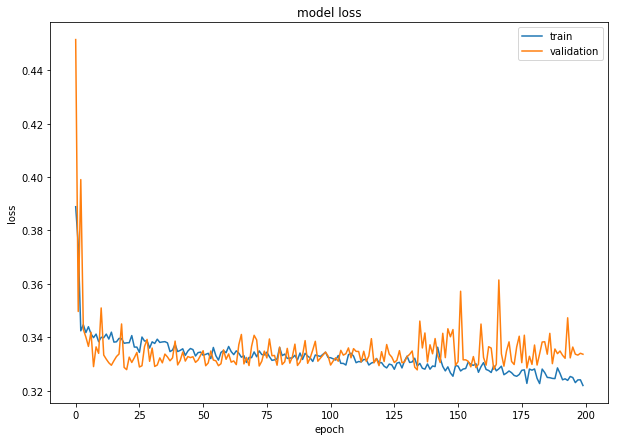

In [27]:
# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [28]:
predict_trend=np.ones(len(X_test))
for i in range(X_test.shape[0]):    
    predict_trend[i]=np.where(best_model.predict(np.expand_dims(X_test[i],axis=0))[0][0]>0.5,1,-1)
predict_trend=np.reshape(predict_trend,(1,-1)).tolist()[0]
Y_test=np.where(y_test==0,-1,1)

# Let us check the accuracy of the model on the test data
from sklearn.metrics import accuracy_score

acc= accuracy_score(list(Y_test),list(predict_trend))

In [29]:
print("The Accuracy of the model on the test set is:",acc*100,'%')
print("\n\n\nThe Signals Predicted\n",list(predict_trend))

The Accuracy of the model on the test set is: 34.0 %



The Signals Predicted
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0]


In [31]:
market_returns=pd.Series(data['Adj. Close'].shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns=pd.Series(predict_trend*market_returns)
intrest_rate=0.06/3
Sharpe=(np.nansum(strategy_returns)-intrest_rate)/strategy_returns.std()
Sharpe

-14.615185282558173

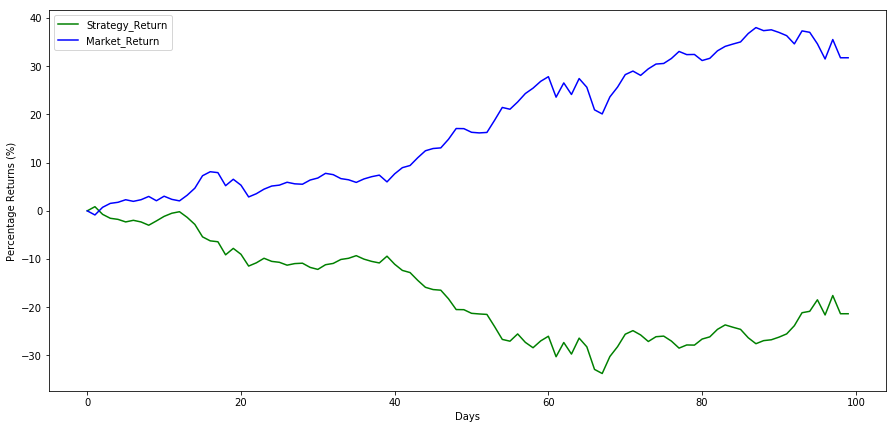

In [32]:
plt.figure(figsize=(15,7))
plt.plot(np.nancumsum(strategy_returns)*100,c='g')
plt.plot(np.nancumsum(market_returns)*100,c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return','Market_Return'])
plt.show()

In [33]:
final_return=np.nansum(strategy_returns)*100
final_return

-21.34328814899593